# Age Estimation task

## Imports

In [3]:
import numpy as np
import pandas as pd
import scipy

# Usual sklearn stuff
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from CustomRegressor import TripleForestWithGenderDivision
from combinationHyperParameters import CombinationHyperParameters

# Distribution analysis
import statistics
from scipy.stats import skew, kurtosis

# Audio processing
import os

import librosa
import librosa.display
import librosa.feature

import parselmouth as pm
import maad as maad
import maad.features
import maad.sound

import parselmouth
from parselmouth.praat import call

# Parallelism libraries
from joblib import Parallel, delayed
from tqdm import tqdm

# Pretty output and plots
from prettytable import PrettyTable

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# import warnings
# warnings.filterwarnings("ignore")

# Not Needed
# %matplotlib widget

## Constants

In [4]:
FILE_DEVELOPMENT = "Dataset/development.csv"
FILE_EVALUATION = "Dataset/evaluation.csv"
AUDIOS_DEVELOPMENT = "Dataset/audios_development/"
AUDIOS_EVALUATION = "Dataset/audios_evaluation/"

COMPUTE_ALL_AUDIO_FEATURES = False

N_MFCC = 35
FREQ_BIN = 32

GenderMapper = {
    'male': 1,
    'female': -1
}

# How to round in the plotting function later on
precisionLog = {
    'mean_pitch':2, 
    'max_pitch':2, 
    'min_pitch':3, 
    'jitter':2, 
    'shimmer':2, 
    'energy':1, 
    'zcr_mean':2, 
    'spectral_centroid_mean':2,
    'tempo':3,
    'hnr':0
}

precisionLinear = {
    'mean_pitch':-1, 
    'max_pitch':-2, 
    'min_pitch':0, 
    'jitter':3, 
    'shimmer':3, 
    'energy':3, 
    'zcr_mean':2, 
    'spectral_centroid_mean':-2,
    'tempo':3,
    'hnr':0
}

# let us try several models
models =[
    LinearRegression(),
    RandomForestRegressor(random_state=341967),
    HistGradientBoostingRegressor(random_state=341967),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor(random_state=341967),
    Lasso(random_state=341967),
    Ridge(random_state=341967),
    DecisionTreeRegressor(random_state=341967),
    TripleForestWithGenderDivision()
]
names=['Linear reg', 'Random Forest', 'HistGB', 'SVR', 'KNN', 'MLP', 'Lasso', 'Ridge', 'Decision Tree', 'Tfr']

# Which audio feature to choose in the various files
columns_correlator = {
    k:v for k,v in zip(
        [
            "time_domain.csv", 
            "freq_domain.csv", 
            "spectrogram.csv", 
            "mel_spectrogram.csv", 
            "mfcc.csv", 
            "hpss.csv", 
            "zcr.csv", 
            "poly.csv", 
            "formants.csv",
            "temporal_median.csv",
            "entropy.csv"
        ], 
        [
            ['audio_length','mean_absolute_slope','pitch_iqr','voiced_frames','number_of_frames','sm','sv','ss','sk','Time 5%','Time 25%','Time 50%','Time 75%','Time 95%','duration_50','duration_90'], 
            ['dominant_frequency'], 
            ['spect_overall_mean'] + [f"spect_frequency_mean_{t}" for t in range(FREQ_BIN)],
            ['mel_overall_mean'] + [f"mel_frequency_mean_{t}" for t in range(FREQ_BIN)],
            [f"mfcc_frequency_mean_{t}" for t in range(N_MFCC)],
            ['harmonic_overall_mean', 'harmonic_overall_var', 'percussion_overall_mean', 'percussion_overall_var'] + [f"harmonic_frequency_mean_{t}" for t in range(FREQ_BIN)] + [f"harmonic_frequency_var_{t}" for t in range(FREQ_BIN)] + [f"percussion_frequency_mean_{t}" for t in range(FREQ_BIN)] + [f"percussion_frequency_var_{t}" for t in range(FREQ_BIN)],
            ['zcr'],
            ['mean_coeffs', 'std_coeffs'],
            ['f0_mean','f1_mean','f2_mean','f3_mean','f4_mean','f0_var','f1_var','f2_var','f3_var','f4_var'],
            ['temporalMedian'],
            ['temporal_entropy', 'frequence_entropy','mean_spectral_entropy']
        ]
    )
}

## Data reading

In [5]:
dev_original_df = pd.read_csv(FILE_DEVELOPMENT, header=0, index_col=0)
eval_original_df = pd.read_csv(FILE_EVALUATION, header=0, index_col=0)

audio_dev = os.listdir(AUDIOS_DEVELOPMENT)
audio_eval = os.listdir(AUDIOS_EVALUATION)

print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '10.wav', '100.wav', '1000.wav', '1001.wav']
['1.wav', '10.wav', '100.wav', '101.wav', '102.wav']


Order audios by integers and in increasing order

In [6]:
audio_dev.sort(key=lambda x: int(x.split('.')[0]))
audio_eval.sort(key=lambda x: int(x.split('.')[0]))

print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']
['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']


## Tabular Data Exploration

In [7]:
print(f"Total number of nan in development: {dev_original_df.isna().sum().sum()}\n")
print(f"Total number of nan in evaluation: {eval_original_df.isna().sum().sum()}\n")

desc_dev_df = dev_original_df.describe()
desc_eval_df = eval_original_df.describe()

sampling_rate = dev_original_df['sampling_rate'].iloc[0]

print("Standard deviation of sampling_rate:")
print(f"In dev dataset: {float(desc_dev_df.loc['std', 'sampling_rate'])}")
print(f"In eval dataset: {float(desc_eval_df.loc['std', 'sampling_rate'])}")

dev_df = dev_original_df.drop('sampling_rate', axis=1)
eval_df = eval_original_df.drop('sampling_rate', axis=1)

ages_df = dev_df[['age']]
path_dev_df = dev_df[['path']]
path_eval_df = eval_df[['path']]

dev_df.drop(['path'], axis=1, inplace=True)
eval_df.drop('path', axis=1, inplace=True)

display(dev_df.head())
display(eval_df.head())

Total number of nan in development: 0

Total number of nan in evaluation: 0

Standard deviation of sampling_rate:
In dev dataset: 0.0
In eval dataset: 0.0


,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,,
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905


,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,male,spanish,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,[80.74951172],-116.662338,69,281,2,38.198503
1,male,xiang,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,[89.10290948],-78.253824,69,281,27,29.605442
2,male,igbo,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,[123.046875],-71.630742,6,22,2,2.275556
3,female,spanish,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,[123.046875],-101.533013,69,281,31,22.151837
4,male,spanish,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,[112.34714674],-134.914070,69,281,35,22.430476


## Preprocess tabular data

### Encoding

#### Ethnicity

In [8]:
enticity_df = dev_df['ethnicity'].value_counts().sort_values(ascending=False)

median_et = enticity_df.median()
mean_et = enticity_df.mean()

print(f"Number of total distinct ethnicities: {enticity_df.shape[0]}")
print(f"Number of ethnicities with only one appearance: {enticity_df[enticity_df == 1].shape[0]}")
print(f"Median value: {median_et}")
print(f"Mean value: {mean_et}")

display(enticity_df)

# enticity_df[enticity_df > mean_et].plot()

etnie_chosen = sorted(list(set(enticity_df[enticity_df > median_et].index))) + ['others']

print(f"Number of ethnicities kept: {etnie_chosen.__len__()}")

display('Ethnicities in eval dataset kept after analysis:')
display(eval_df.loc[eval_df['ethnicity'].isin(etnie_chosen), 'ethnicity'].value_counts())

Number of total distinct ethnicities: 165
Number of ethnicities with only one appearance: 58
Median value: 2.0
Mean value: 17.775757575757577


ethnicity
igbo        1081
english      579
arabic       102
mandarin      65
french        63
            ... 
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, Length: 165, dtype: int64

Number of ethnicities kept: 77


'Ethnicities in eval dataset kept after analysis:'

ethnicity
igbo         232
yoruba         5
igala          4
ibibio         2
congolese      1
urhobo         1
nigerian       1
hausa          1
Name: count, dtype: int64

In [9]:
def encode_ethnicity(X_df:pd.DataFrame):
    aggregated_ethnicity_df = X_df.copy()

    try:
        aggregated_ethnicity_df.drop(columns=['ethnicity'], axis=1, inplace=True)
    except KeyError:
        pass

    return aggregated_ethnicity_df

#### Gender

In [10]:
display(dev_original_df['gender'].value_counts())
display(eval_original_df['gender'].value_counts())

gender
female    1468
male      1465
Name: count, dtype: int64

gender
male      393
female    297
famale      1
Name: count, dtype: int64

In [11]:
def encode_gender(X_df:pd.DataFrame, mapper):
    encoded_df = X_df.copy()
    for gender, value in mapper.items():
        encoded_df.loc[encoded_df['gender'] == gender, 'gender'] = value

    encoded_df.loc[encoded_df['gender'] == 'famale', 'gender'] = GenderMapper['female']

    encoded_df['gender'] = encoded_df['gender'].astype(float)
    return encoded_df

#### Tempo

In [12]:
print(f"""Number of values in column 'tempo' that do not start with '[':
    1.In dev: {dev_df[dev_df['tempo'].map(lambda x: x[0]) == '['].shape[0] - dev_df.shape[0]}
    2.In eval: {dev_df[dev_df['tempo'].map(lambda x: x[0]) == '['].shape[0] - dev_df.shape[0]}""")

Number of values in column 'tempo' that do not start with '[':
    1.In dev: 0
    2.In eval: 0


In [13]:
def encode_tempo(X_df):
    encoded_df = X_df.copy()

    encoded_df['tempo'] = encoded_df['tempo'].map(lambda x: float(x.strip('[').strip(']')))
    
    return encoded_df

### Results of Encoding

In [14]:
step1_dev_df = encode_ethnicity(dev_df)
step1_eval_df = encode_ethnicity(eval_df)

step2_dev_df = encode_gender(step1_dev_df, GenderMapper)
step2_eval_df = encode_gender(step1_eval_df, GenderMapper)

step3_dev_df = encode_tempo(step2_dev_df)
step3_eval_df = encode_tempo(step2_eval_df)

display(step3_dev_df.head(5))
display(step3_eval_df.head(5))

display(step3_dev_df.describe())
display(step3_eval_df.describe())

,age,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,24.0,-1.0,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893
1,22.5,-1.0,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662
2,22.0,-1.0,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998
3,22.0,-1.0,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127
4,22.0,1.0,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,
0,1.0,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,80.749512,-116.662338,69,281,2,38.198503
1,1.0,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,89.102909,-78.253824,69,281,27,29.605442
2,1.0,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,123.046875,-71.630742,6,22,2,2.275556
3,-1.0,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,123.046875,-101.533013,69,281,31,22.151837
4,1.0,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,112.347147,-134.914070,69,281,35,22.430476


,age,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
count,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,27.897886,-0.001023,1189.536569,3779.570485,146.934930,0.021190,0.107741,0.005208,0.104774,2176.369847,125.085771,-74.526288,41.307535,167.936243,12.423116,13.501159
std,13.093316,1.000170,414.193673,532.847869,3.757917,0.006626,0.029005,0.006074,0.051646,578.925294,33.812698,38.446856,32.782431,133.816974,14.273205,10.839142
min,6.000000,-1.000000,346.974330,935.515560,145.349140,0.007292,0.045205,0.000028,0.015947,692.116731,51.679688,-193.693345,0.000000,0.000000,1.000000,0.668345
25%,19.000000,-1.000000,818.922360,3948.234400,145.419140,0.016734,0.087378,0.001960,0.060733,1740.756716,103.359375,-104.555692,4.000000,14.000000,1.000000,1.732925
50%,23.000000,-1.000000,1208.998300,3998.397200,145.622010,0.020525,0.104697,0.003716,0.098964,2150.814043,117.453835,-84.415550,69.000000,281.000000,8.000000,17.368526
75%,32.000000,1.000000,1523.777700,3999.485400,146.820890,0.024558,0.124993,0.006338,0.139559,2566.190670,143.554688,-40.339359,69.000000,281.000000,20.000000,21.408798
max,97.000000,1.000000,2724.892800,3999.792500,202.040700,0.096153,0.265167,0.129114,0.335976,4144.132595,287.109375,12.403661,69.000000,281.000000,97.000000,83.777596


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,0.137482,1191.041077,3832.214580,146.591685,0.021320,0.110438,0.005074,0.105111,2214.701841,126.437846,-84.551539,43.946454,178.522431,15.698987,14.982523
std,0.991222,379.826928,451.201809,3.212186,0.006399,0.029365,0.005430,0.050162,571.250581,33.134285,36.514264,32.019084,130.933540,16.957466,11.040405
min,-1.000000,419.396150,1151.012200,145.349230,0.009395,0.035001,0.000056,0.018496,803.534172,54.978391,-155.826124,0.000000,0.000000,1.000000,0.925669
25%,-1.000000,865.617580,3955.649050,145.401825,0.017184,0.089501,0.001851,0.064549,1785.536118,103.359375,-112.362377,5.000000,17.000000,1.000000,2.115329
50%,1.000000,1209.680400,3998.631300,145.529140,0.020670,0.106233,0.003582,0.098416,2174.406614,123.046875,-92.686476,69.000000,281.000000,11.000000,18.552744
75%,1.000000,1487.326050,3999.521850,146.396920,0.024536,0.126537,0.006147,0.135834,2580.589333,143.554688,-59.687405,69.000000,281.000000,26.000000,23.010975
max,1.000000,2201.411000,3999.790800,186.688950,0.077450,0.246068,0.048074,0.335676,4753.076563,258.398438,11.653742,69.000000,281.000000,76.000000,57.663855


### Behavior analysis and $log_{10}$ scaling

#### Insight

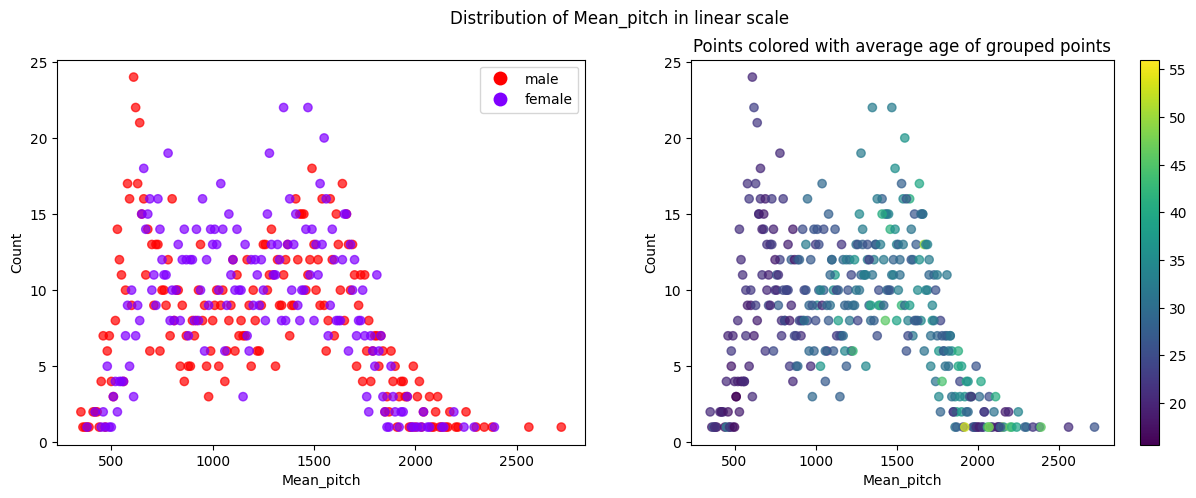

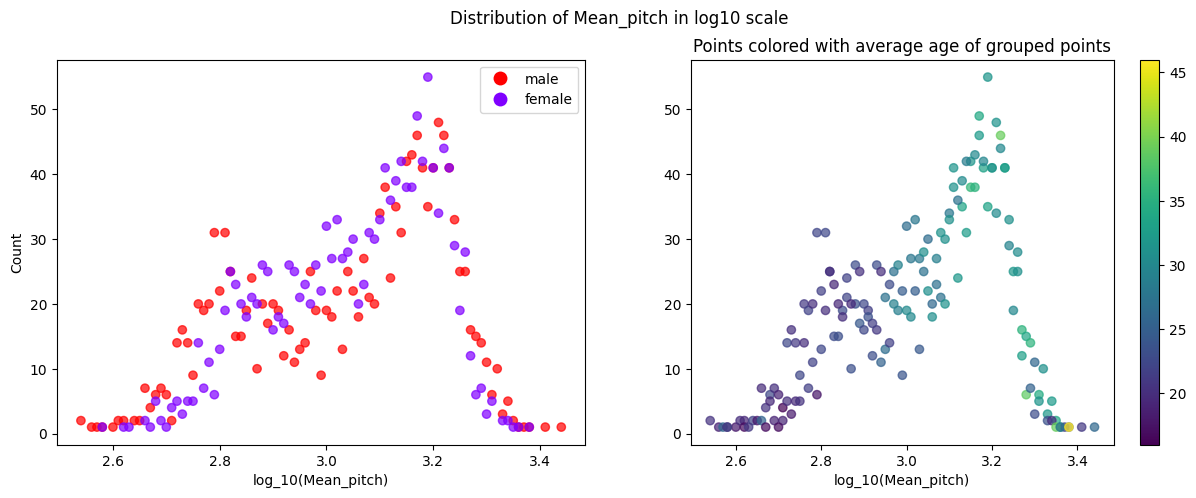

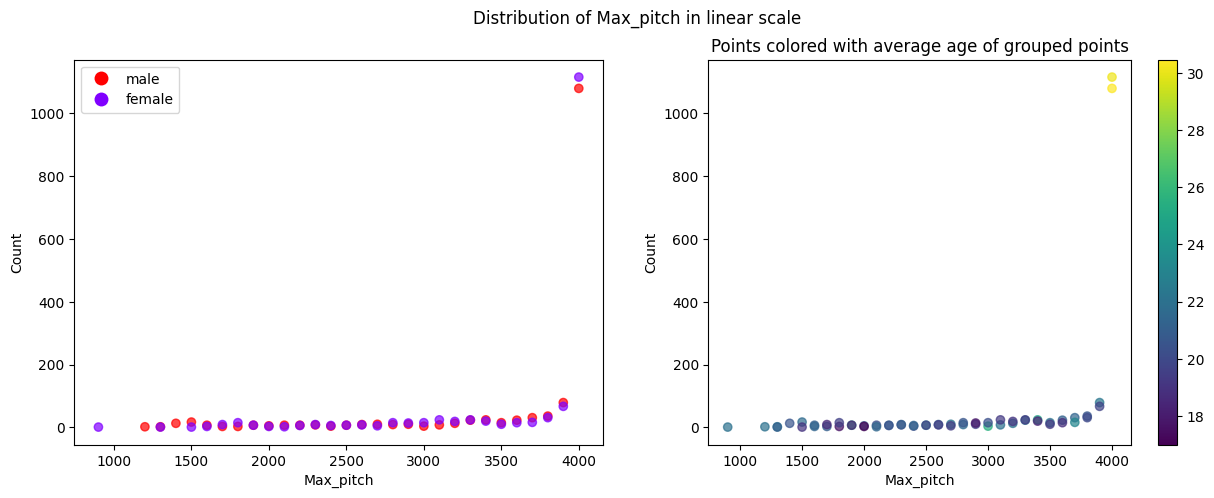

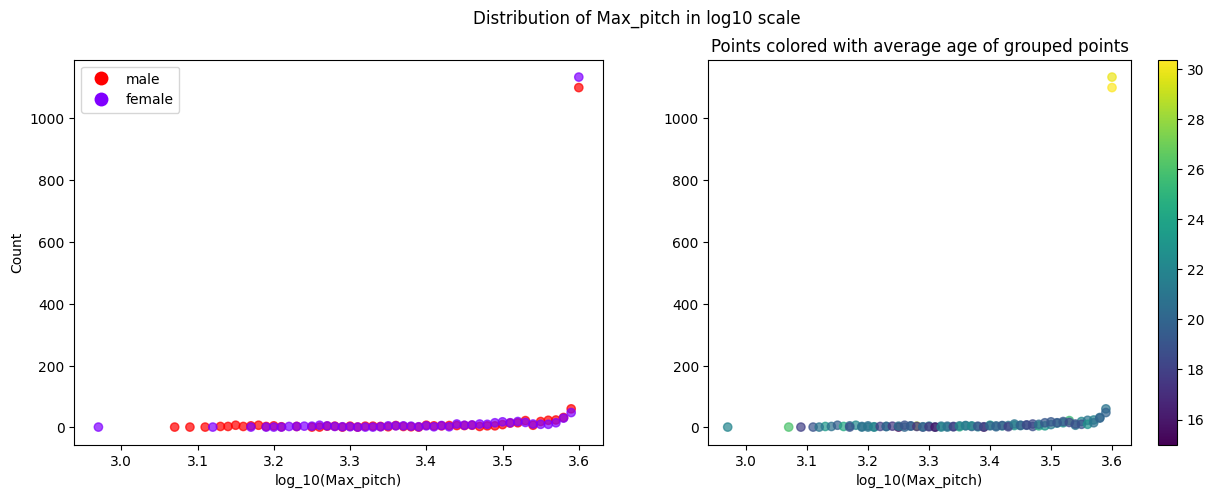

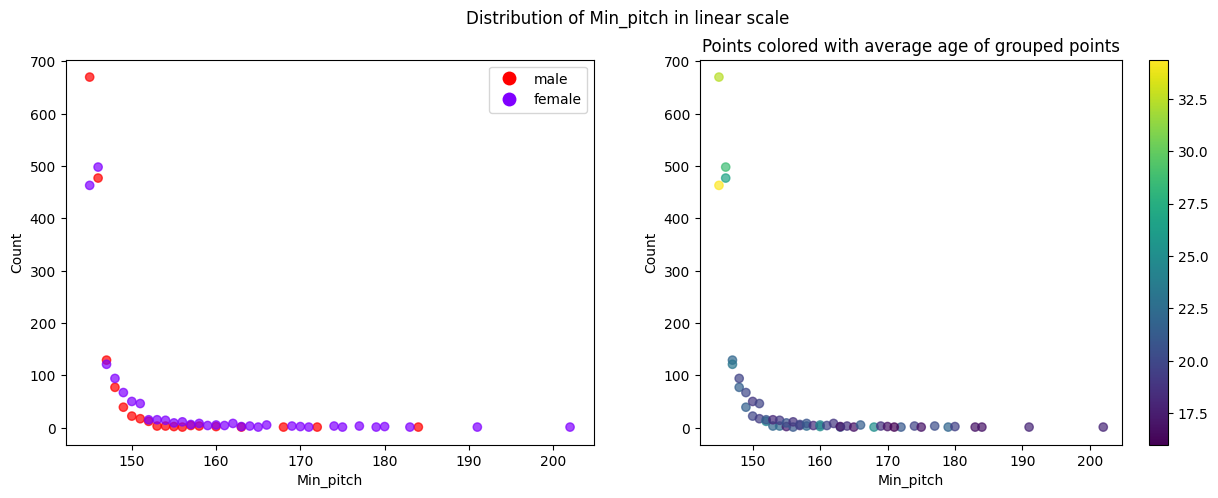

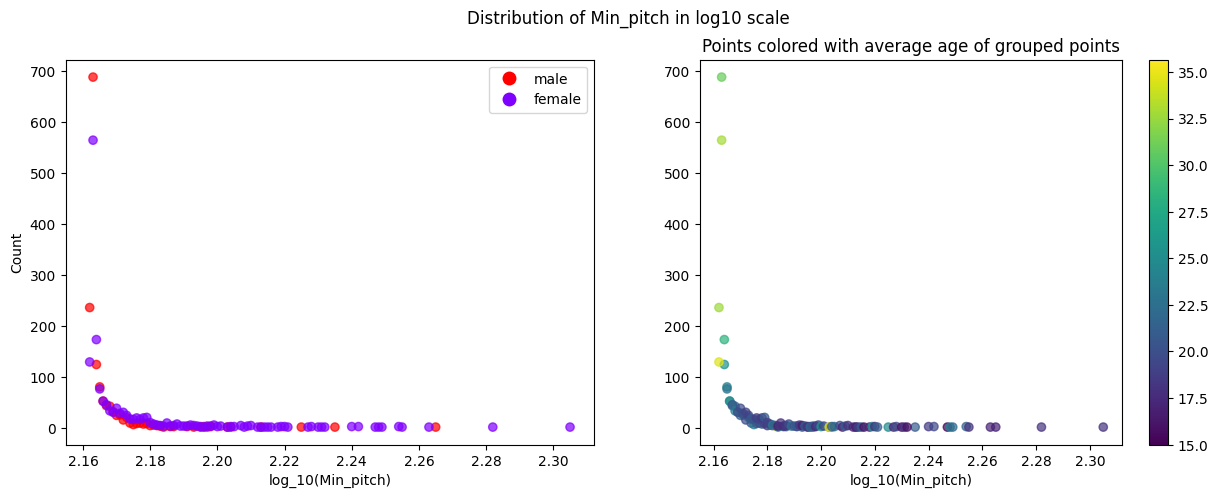

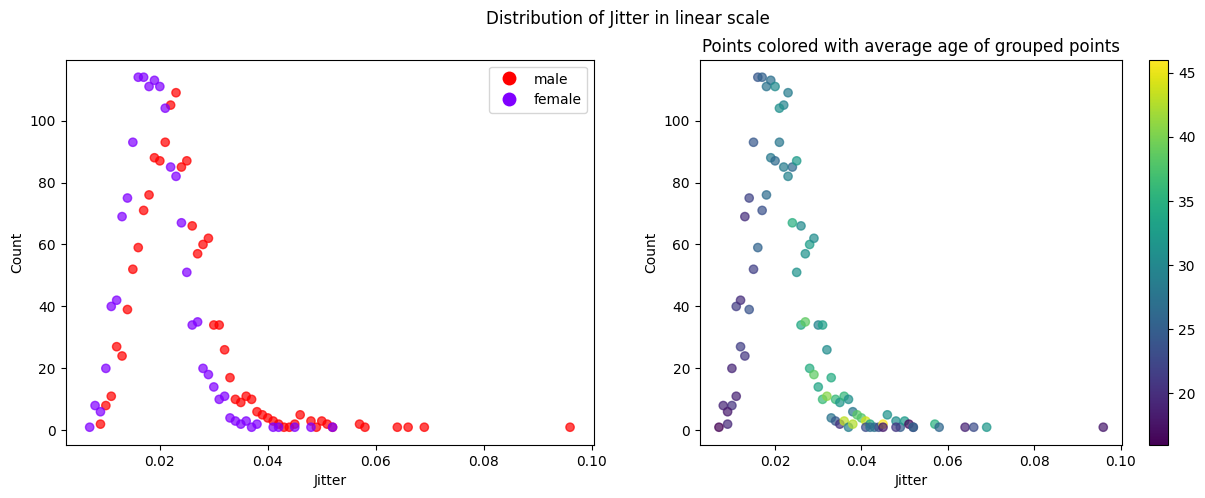

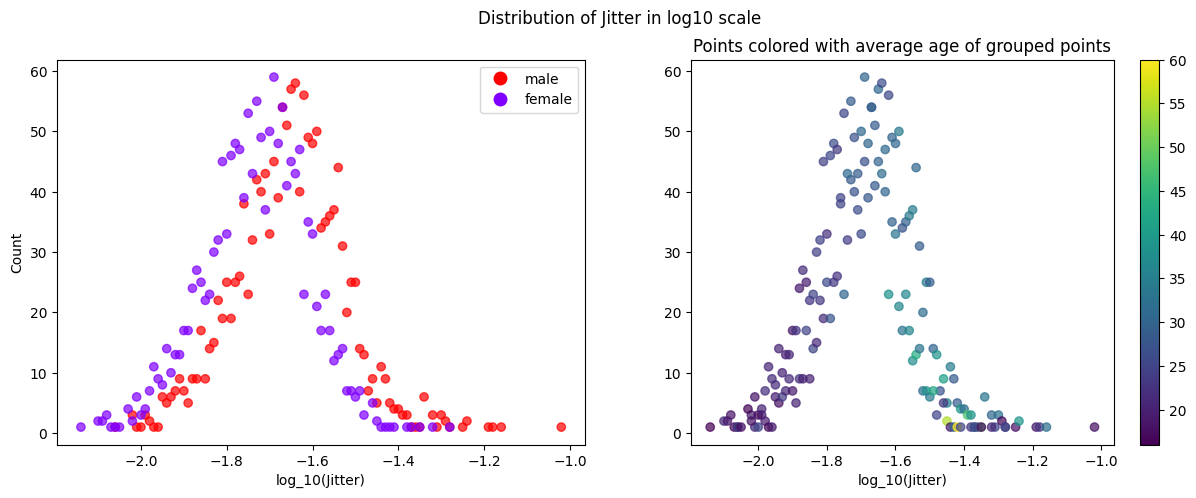

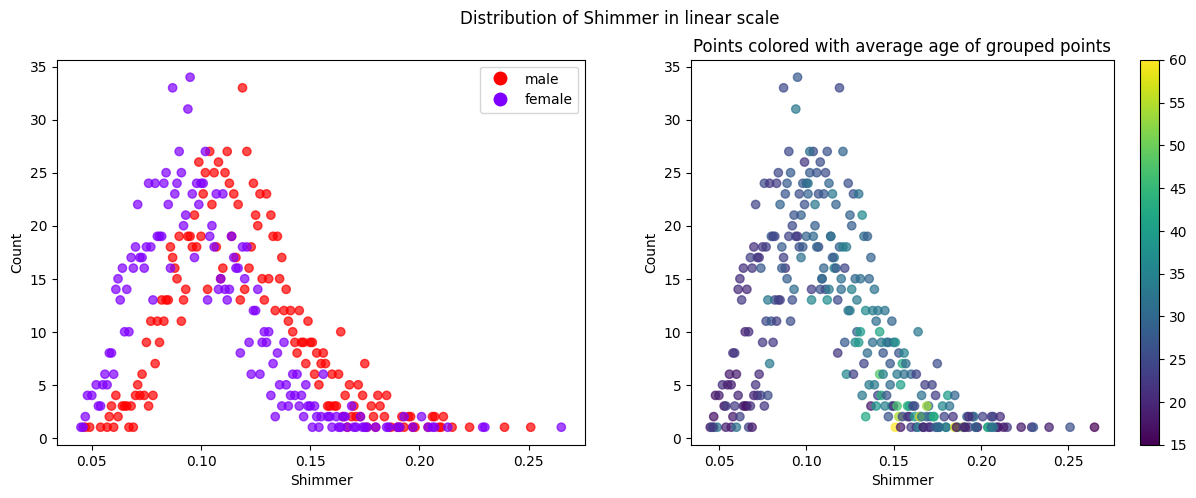

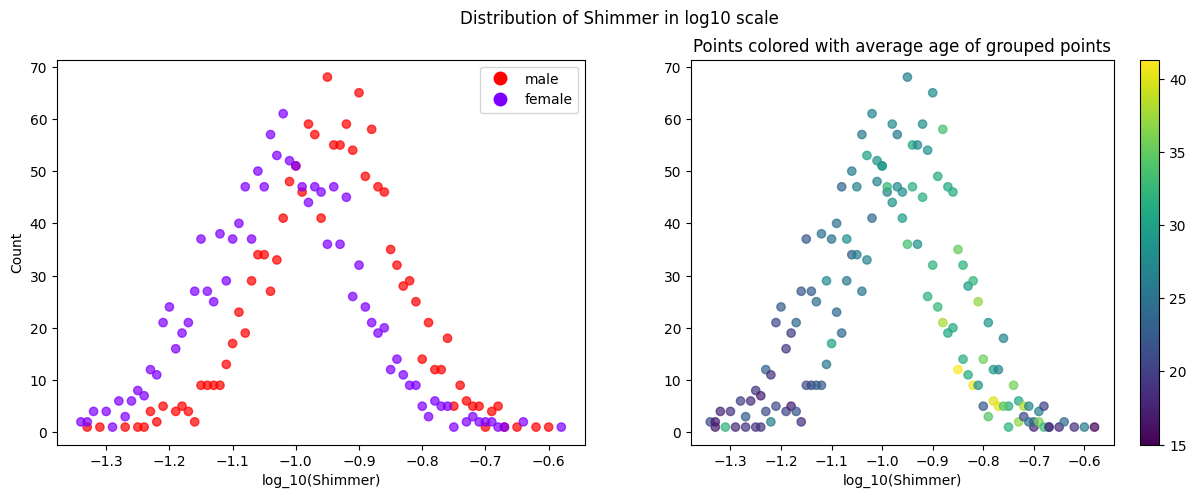

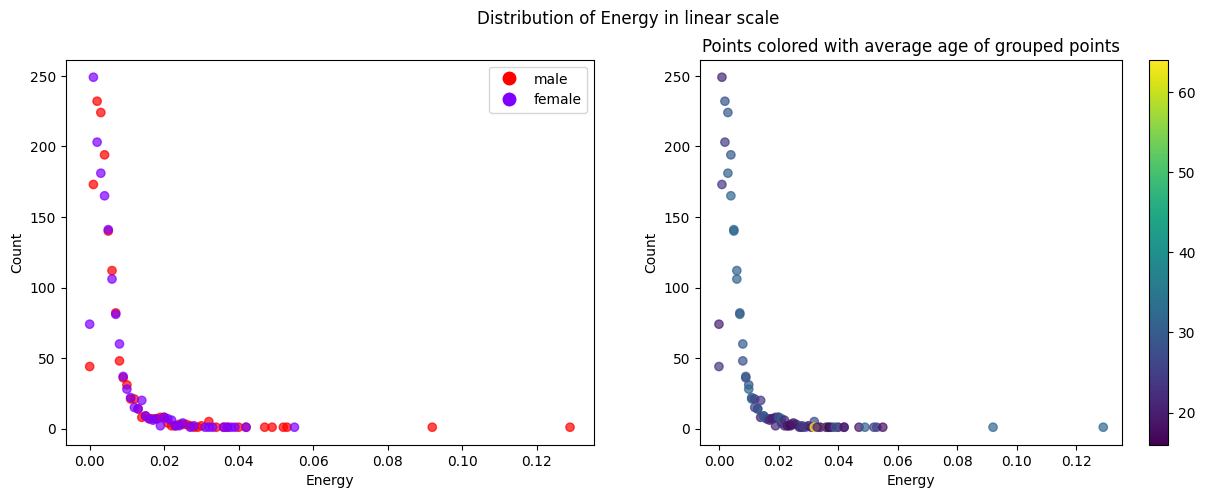

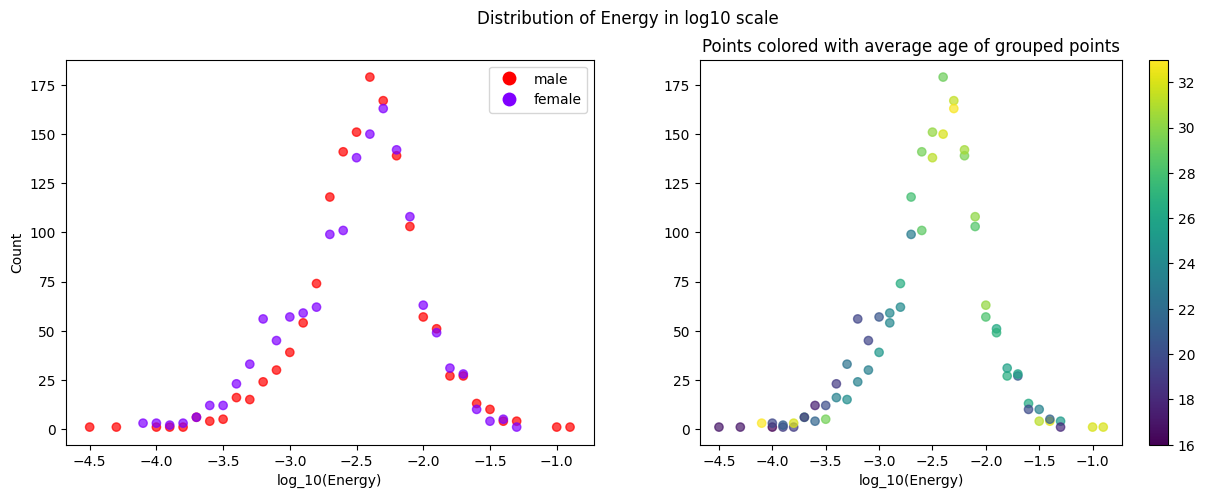

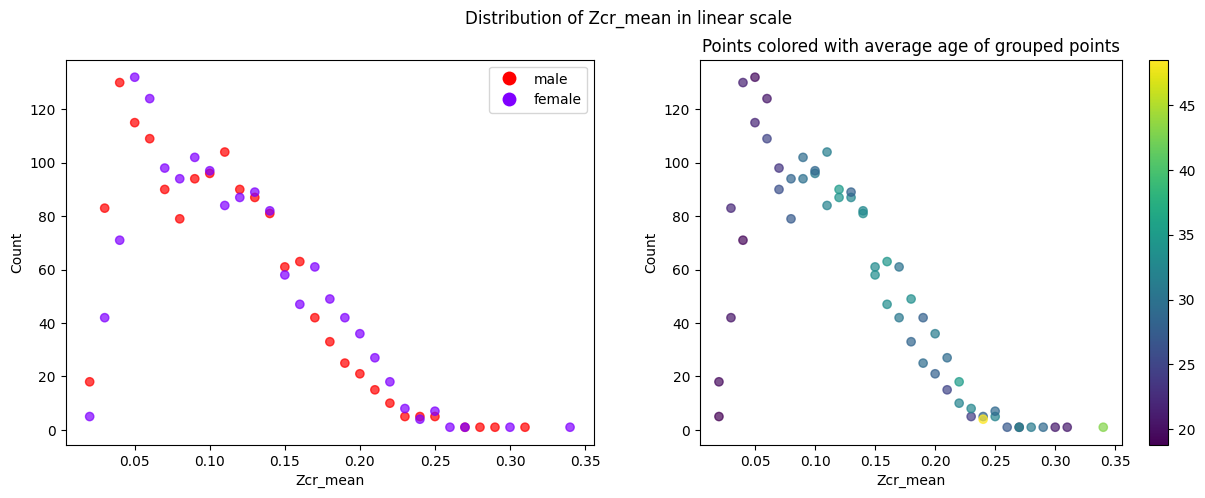

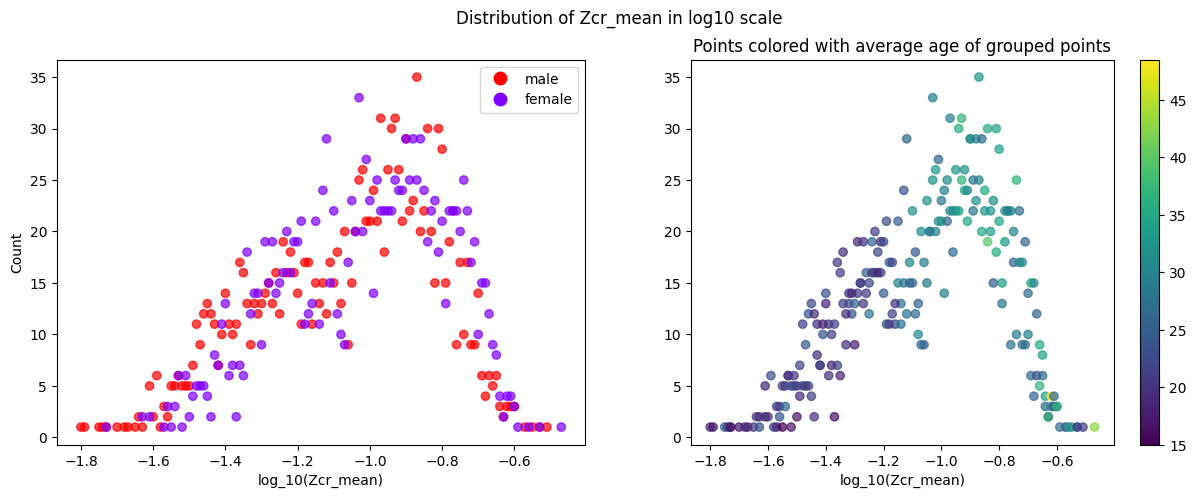

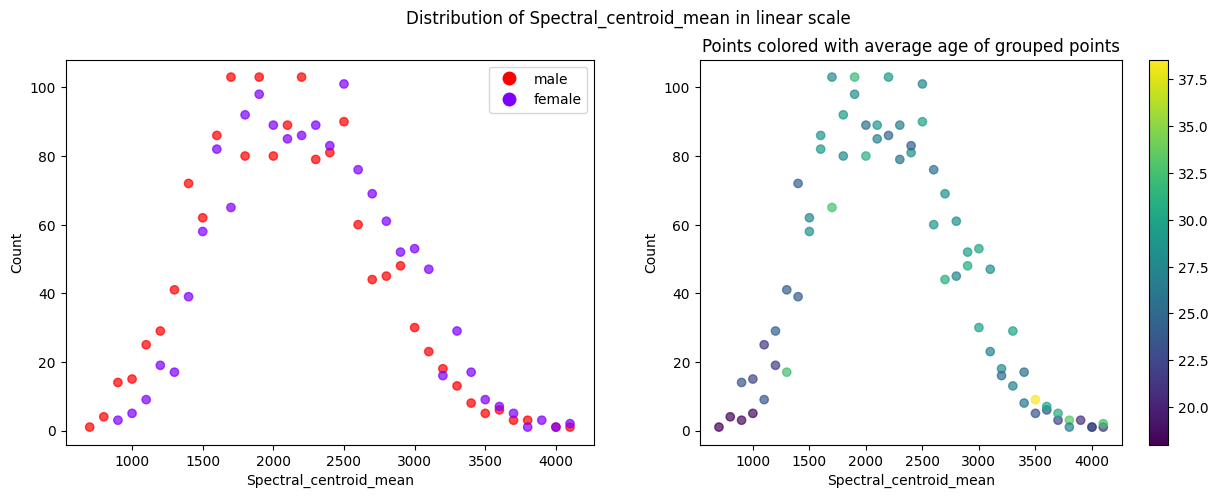

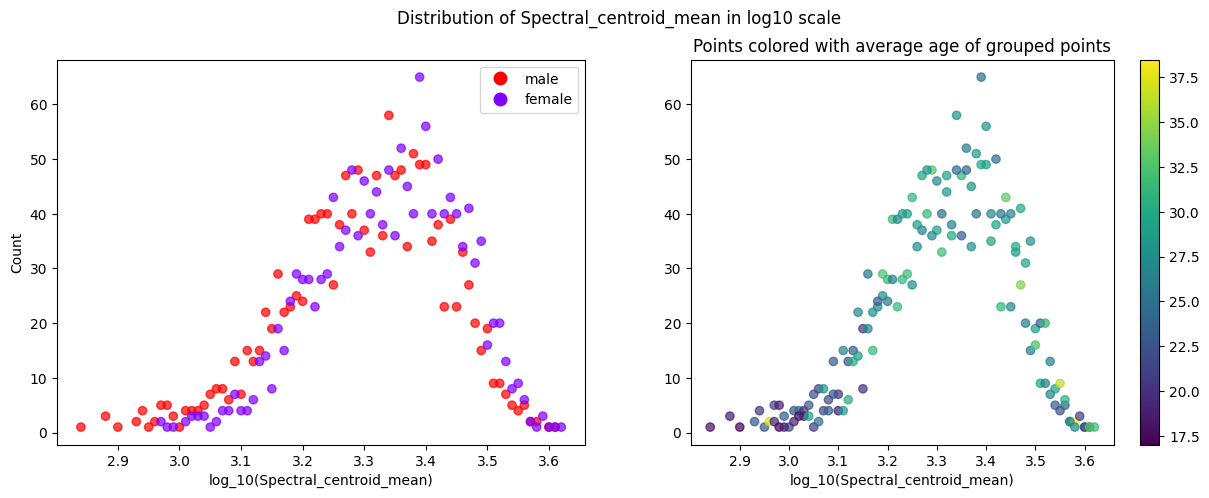

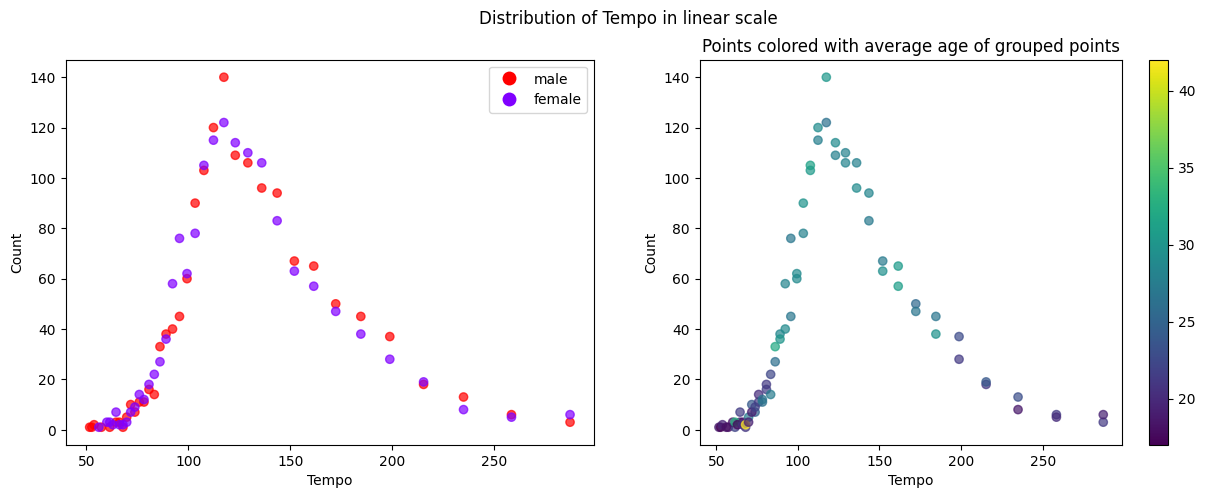

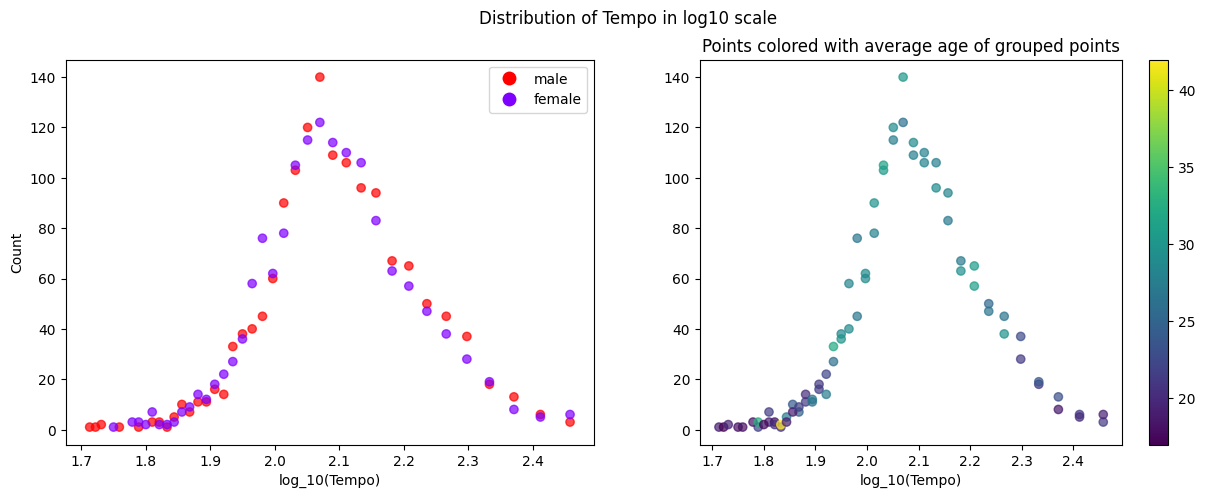

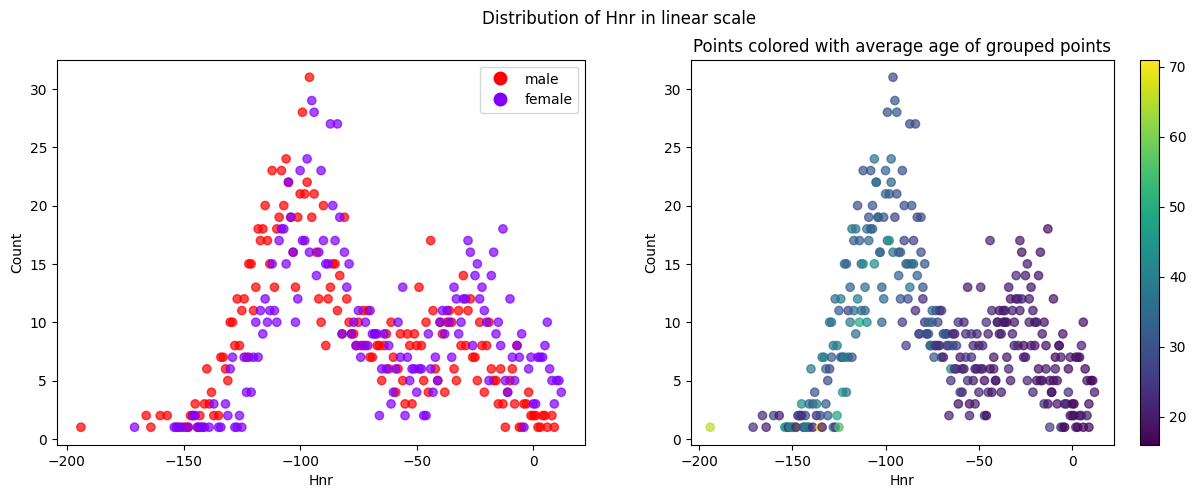

In [15]:
def create_colors(values:pd.Series, label:str, use_continous:bool=False, 
                  cmap_continuous = cm.viridis, cmap_discrete = cm.rainbow):
    if use_continous:
        cmap_ = cmap_continuous
        # Alternative normalization without iterquartile ranges:
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap_)
        handles = None
    else:
        cmap_ = cmap_discrete
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = None
        handles = [
            Line2D(
                [0], [0], marker='o', color='none', linestyle='None', 
                markeredgewidth=0, markerfacecolor=cmap_(norm(val)), 
                markersize=10, label=label
            ) for label, val in GenderMapper.items()
        ]

    return cmap_, norm, mappable, handles 

def round_column(data: pd.DataFrame, col: str, isLog:bool = True):
    if col != 'hnr':
        if isLog:
            rounded_col = np.round(
                np.log10(data[col]), 
                precisionLog[col]
            )
        else:
            rounded_col = np.round(
                data[col],
                precisionLinear[col]
            )
    else:
        rounded_col = np.round(data[col], precisionLinear[col])
    return rounded_col


def perform_aggregation(partition_df, col, target, gender, descrete):
    grouped_temp = partition_df.groupby(col).agg({
        'frequency': 'first',
    })

    if not descrete:
        grouped_temp['target'] = grouped_temp.index.map(
            lambda val: target.loc[partition_df[partition_df[col] == val].index, :].mean().iloc[0]
        )
    else:
        grouped_temp['target'] = GenderMapper[gender]

    grouped_temp = grouped_temp.reset_index()

    return grouped_temp
    
def plot_distribution(fig:plt.Figure, ax:plt.Axes, X_df:pd.DataFrame, col:str, target:pd.Series, isLog:bool=True, descrete:bool=False):    
    temp = X_df[['gender', col]].copy()

    temp[col] = round_column(temp, col, isLog=isLog)

    male_df = temp[temp['gender'] == GenderMapper['male']].copy()
    female_df = temp[temp['gender'] == GenderMapper['female']].copy()

    male_df['frequency'] = male_df[col].map(male_df[col].value_counts())
    female_df['frequency'] = female_df[col].map(female_df[col].value_counts())

    male_grouped_df = perform_aggregation(male_df, col, target, 'male', descrete)
    female_grouped_df = perform_aggregation(female_df, col, target, 'female', descrete)

    female_grouped_df.index = female_grouped_df.index + male_grouped_df.index[-1]

    combined_df = pd.concat([male_grouped_df, female_grouped_df]).reset_index()

    cmap_, norm, mappable, handles = create_colors(combined_df.loc[:, 'target'], label='gender', use_continous=not descrete)

    ax.scatter(
        combined_df[col], 
        combined_df['frequency'], 
        c=cmap_(norm(combined_df['target'])), 
        alpha=0.7
    )

    if mappable:
        fig.colorbar(mappable=mappable, ax=ax)
    else:
        ax.legend(handles=handles)

def tabular_data_distribution():
    for i in range(9):
        col = list(precisionLog.keys())[i]

        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

        ax1 = fig.add_subplot(121)
        plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
        ax1.set_xlabel(f'{col.capitalize()}')
        ax1.set_ylabel(f'Count')
        
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points colored with average age of grouped points")
        plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
        ax2.set_ylabel(f'Count')
        ax2.set_xlabel(f'{col.capitalize()}')
        plt.show()


        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'Distribution of {col.capitalize()} in log10 scale')

        ax1 = fig.add_subplot(121)
        plot_distribution(fig, ax1, step3_dev_df, col, ages_df, isLog=True, descrete=True)
        ax1.set_xlabel(f'log_10({col.capitalize()})')
        ax1.set_ylabel(f'Count')
        
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points colored with average age of grouped points")

        plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=True, descrete=False)
        ax2.set_xlabel(f'log_10({col.capitalize()})')
        ax1.set_ylabel(f'Count')
        plt.show()

    col = list(precisionLog.keys())[9]

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

    ax1 = fig.add_subplot(121)
    plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
    ax1.set_xlabel(f'{col.capitalize()}')
    ax1.set_ylabel(f'Count')

    ax2 = fig.add_subplot(122)
    ax2.set_title("Points colored with average age of grouped points")
    plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
    ax2.set_xlabel(f'{col.capitalize()}')
    ax2.set_ylabel(f'Count')
    plt.show()

tabular_data_distribution()

#### In practice

In [16]:
step3_log_dev_df = step3_dev_df.copy()
step3_log_eval_df = step3_eval_df.copy()

for i, toSub in zip(precisionLog.keys(), [1, 0, 0, 1, 1, 1, 1, 1, 0, 0]):
    if toSub == 1:
        step3_log_dev_df.loc[:, i] = np.log10(step3_dev_df.loc[:, i])
        step3_log_eval_df.loc[:, i] = np.log10(step3_eval_df.loc[:, i])

## Correlation

age                       1.000000
silence_duration          0.514127
num_words                 0.473499
num_characters            0.473403
num_pauses                0.437670
mean_pitch                0.327427
zcr_mean                  0.313140
jitter                    0.270149
max_pitch                 0.226643
shimmer                   0.223070
energy                    0.146518
spectral_centroid_mean    0.056151
gender                    0.023184
tempo                    -0.040547
min_pitch                -0.224201
hnr                      -0.446880
Name: age, dtype: float64

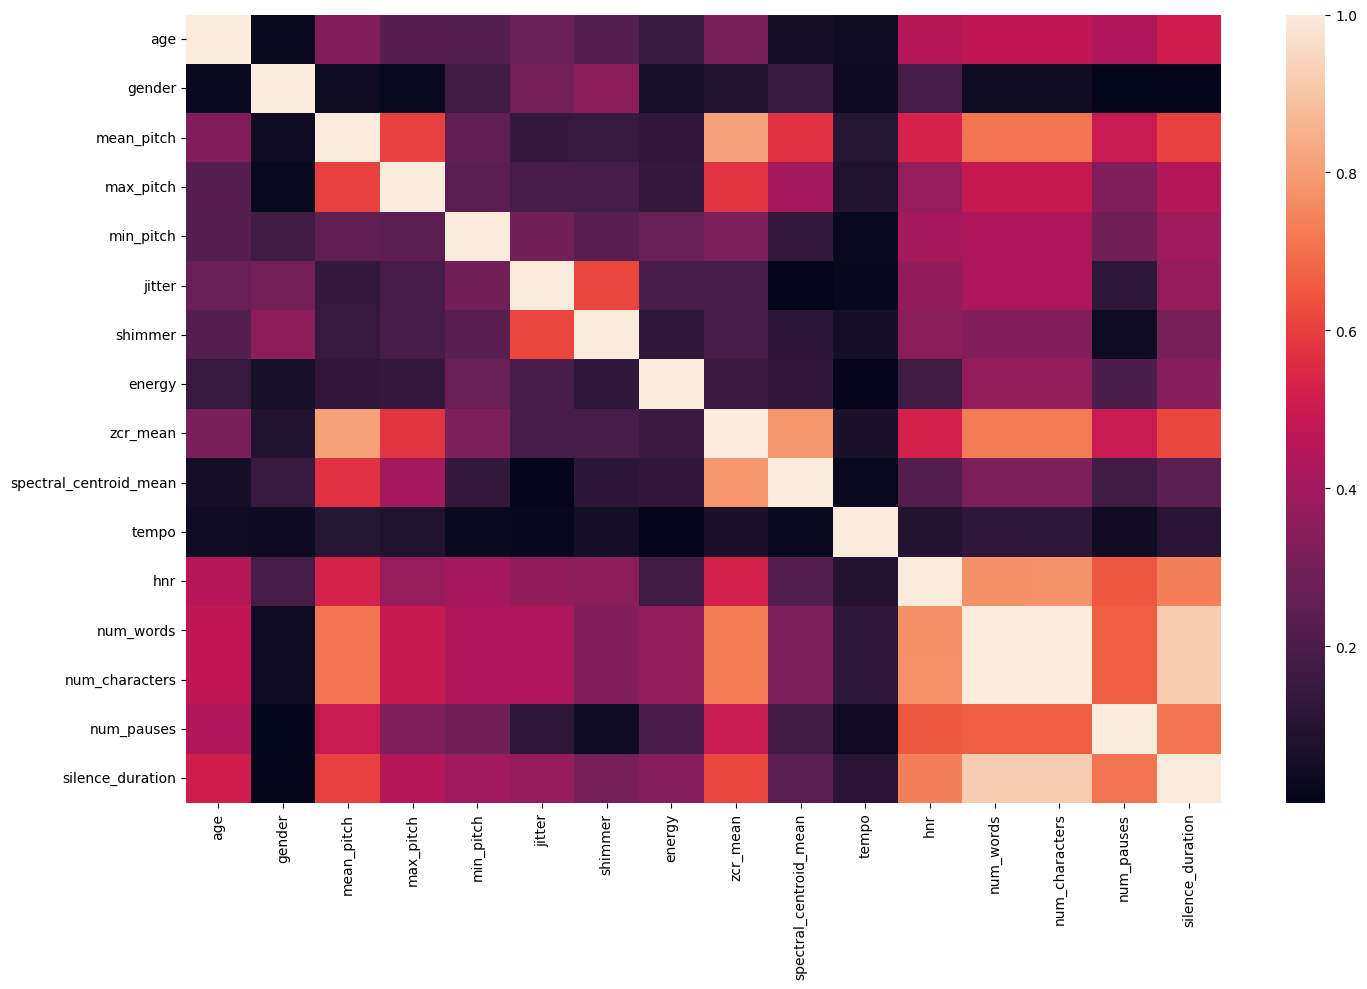

In [17]:
temp:pd.Series = step3_log_dev_df.corr().loc['age', :].sort_values(ascending=False)
display(temp)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
sns.heatmap(np.abs(step3_log_dev_df.corr()), ax=ax)
plt.tight_layout()

## Standardization

In [18]:
no_age_dev_df = step3_log_dev_df.drop(columns=['age'], axis=1)

scaler = StandardScaler().fit(no_age_dev_df)

step3_log_norm_dev_df = pd.DataFrame(scaler.transform(no_age_dev_df), columns=no_age_dev_df.columns)
step3_log_norm_eval_df = pd.DataFrame(scaler.transform(step3_log_eval_df), columns=step3_log_eval_df.columns)

display(step3_log_norm_dev_df.head())
display(step3_log_norm_eval_df.head())

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,-0.998978,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,-1.287020,0.844879,0.845057,1.862330,0.954642
1,-0.998978,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,-0.322635,0.844879,0.845057,0.601010,0.543263
2,-0.998978,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,-0.622378,0.844879,0.845057,-0.800455,0.751095
3,-0.998978,0.661310,0.410845,0.278367,-0.592809,-0.057508,1.920345,1.182793,1.593684,-0.225751,0.469989,0.844879,0.845057,-0.239869,0.566836
4,1.001023,1.096713,0.411146,-0.395821,1.093041,0.682511,0.474725,0.292051,-0.295562,-0.376805,-0.151479,0.844879,0.845057,-0.099722,0.418993


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,1.001023,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,-1.096143,0.844879,0.845057,-0.730382,2.278922
1,1.001023,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,-0.096969,0.844879,0.845057,1.021450,1.486006
2,1.001023,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,0.075326,-1.077210,-1.090752,-0.730382,-1.035831
3,-0.998978,0.598590,0.411678,-0.405267,1.003108,-0.584964,1.508214,0.106896,-0.484025,-0.060310,-0.702563,0.844879,0.845057,1.301743,0.798232
4,1.001023,1.010125,0.413308,-0.418335,0.217608,-0.004417,-0.909264,0.796607,0.680233,-0.376805,-1.570950,0.844879,0.845057,1.582037,0.823943


## Error plot

In [19]:
def plot_error_distripution(y_pred, y_val, precision):
    errors = pd.DataFrame(np.round(y_pred.flatten() - y_val.values.flatten(), precision), columns=['error'])
    error_counts = errors['error'].value_counts().reset_index()
    error_counts.columns = ['error', 'count']

    plt.figure()
    plt.scatter(error_counts['error'], error_counts['count'])
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.show()
    return error_counts

In [127]:
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_val_score

# cross_val_score(make_pipeline(StandardScaler(), RandomForestRegressor()), step3_log_dev_df, ages_df, cv=15, scoring='neq_mean_squared_error').mean().abs()

## First regressor

10.954255487613231

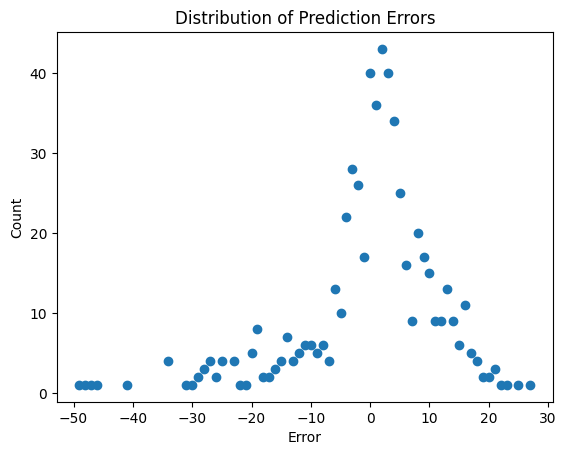

In [23]:
X_train_val_df = step3_log_norm_dev_df.copy()

first_forest = RandomForestRegressor(random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

first_forest.fit(X_train, y_train.values.flatten())
y_pred = first_forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.455056281368881

First look at feature importances

In [24]:
imps = [(a, float(b)) for a,b in sorted(zip(first_forest.feature_names_in_, first_forest.feature_importances_), key=lambda x:x[1] , reverse=True)]
display(imps)

[('silence_duration', 0.34097208305010585),
 ('hnr', 0.07308107428701854),
 ('jitter', 0.06424306744996193),
 ('spectral_centroid_mean', 0.06205885974160902),
 ('shimmer', 0.06191911252022544),
 ('mean_pitch', 0.06190194588900974),
 ('max_pitch', 0.05972452857811777),
 ('min_pitch', 0.05720407155660831),
 ('energy', 0.05694368759294785),
 ('zcr_mean', 0.05244572444521123),
 ('num_pauses', 0.052264215873769136),
 ('tempo', 0.04170968592586419),
 ('gender', 0.012203566962229169),
 ('num_words', 0.001666078907995454),
 ('num_characters', 0.001662297219326421)]

In [30]:
t = PrettyTable(['Model', 'RMSE'])
X_train_val_df = step3_log_norm_dev_df.copy()

for model,name in zip(models, names):
    X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

    model.fit(X_train, y_train.values.flatten())
    y_pred = model.predict(X_val)

    t.add_row([name, root_mean_squared_error(y_val, y_pred)])
print(t)

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

+---------------+--------------------+
|     Model     |        RMSE        |
+---------------+--------------------+
|   Linear reg  | 11.006757028097923 |
| Random Forest | 10.954255487613231 |
|     HistGB    | 10.858568901060597 |
|      SVR      | 11.394273417450163 |
|      KNN      | 12.315983852796776 |
|      MLP      | 10.736732136495514 |
|     Lasso     | 11.158438602590392 |
|     Ridge     | 11.001198425954156 |
| Decision Tree | 15.783781812780429 |
|      Tfr      | 12.163469687388982 |
+---------------+--------------------+


c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_female_df.drop(columns=['gender'], axis=1, inplace=True)


In [26]:
y_dev_pred = first_forest.predict(step3_log_norm_dev_df.values)

print(f"""Max and min value of prediction:
    {float(np.max(y_dev_pred))}, {float(np.min(y_dev_pred))}""")

print(f"""Max and min value of ground truth::
    {float(np.max(ages_df))}, {float(np.min(ages_df))}""")

Max and min value of prediction:
    81.45, 13.72
Max and min value of ground truth::
    97.0, 6.0


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [101]:
with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(first_forest.predict(step3_log_norm_eval_df)):
        fout.write(f"{id},{y}\n")

## Fine tuned

### Forest

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 341967}
Best Cross-Validation Accuracy: -10.851739055578825


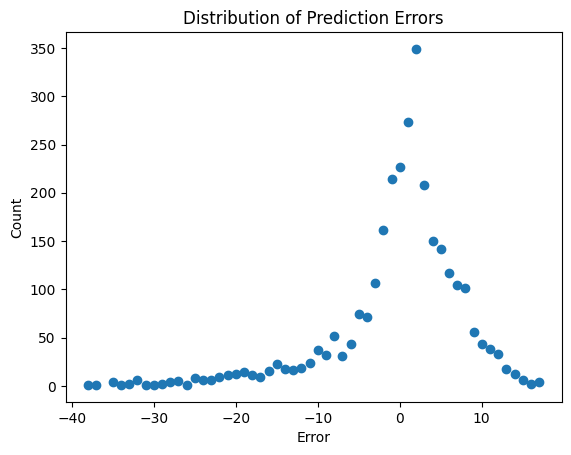

In [35]:
param_grid = {
    'n_estimators': [300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [341967]
}

gs = GridSearchCV(
    RandomForestRegressor(), 
    param_grid, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    cv=5
)

gs.fit(step3_log_norm_dev_df, ages_df)

# Print the best hyperparameters and score
print("Best Hyperparameters:", gs.best_params_)
print("Best Cross-Validation Accuracy:", gs.best_score_)

best_rf = gs.best_estimator_

_ = plot_error_distripution(best_rf.predict(step3_log_norm_dev_df), ages_df, 0)

#10.424189101247185

In [38]:
y_dev_pred = best_rf.predict(step3_log_norm_dev_df.values)

print(f"""Max and min value of prediction:
    {float(np.max(y_dev_pred))}, {float(np.min(y_dev_pred))}""")

print(f"""Max and min value of ground truth::
    {float(np.max(ages_df))}, {float(np.min(ages_df))}""")

Max and min value of prediction:
    63.474001821371715, 16.494994523087097
Max and min value of ground truth::
    97.0, 6.0


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Our Regressor

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

12.145062175335283

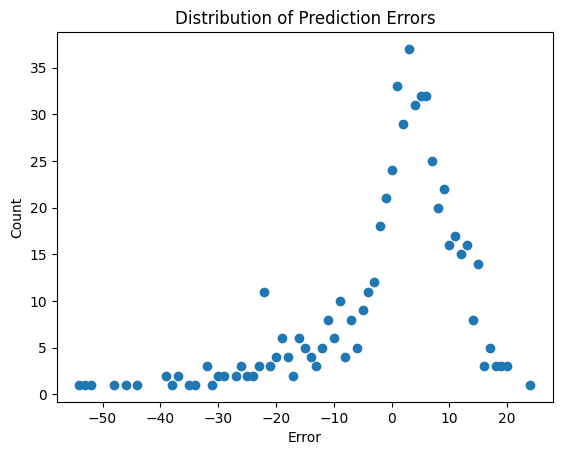

c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_female_df.drop(columns=['gender'], axis=1, inplace=True)


In [37]:
tfr = TripleForestWithGenderDivision(        
    {'n_estimators': 100,  'random_state': 341967}, 
    {'n_estimators': 100, 'random_state': 341967}, 
    {'n_estimators': 100,  'random_state': 341967}
)

X_train, X_val, y_train, y_val = train_test_split(step3_log_norm_dev_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

tfr.fit(X_train, y_train)

y_pred = tfr.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred.values, y_val, 0)

y_eval_pred = tfr.predict(step3_log_norm_eval_df)

In [ ]:
with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")

## Preprocess audio

### Feature extraction functions

In [39]:
def plot_audio(y:np.ndarray, sr:float, time=False, freq=False, spectrogram=False, mel=False, mfcc=False, hp=False, poly=False,plot=True):
    """
        Returns the thing plotted\n
        If freq = True, returns the frequencies used too\n
        If hp=True, returns Harmonic and Percussion\n
        If all False, returns y
    """
    n_fft = (FREQ_BIN - 1) * 2

    if time:
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Audio as waveform")
            librosa.display.waveshow(y, sr=sr)

        return y
    if freq:
        y_freq = np.abs(scipy.fft.fft(y))
        f = np.linspace(0, sr, len(y_freq))
        
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Spectrum of audio")
            plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
            plt.xlabel("Frequency (Hz)")

        return y_freq, f
    if spectrogram:    
        y_stft = np.abs(librosa.stft(y, n_fft=n_fft))
        y_stft_db = librosa.amplitude_to_db(y_stft, ref=np.max)
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Spectrogram of audio")
            librosa.display.specshow(y_stft_db, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.1f dB")

        return y_stft, y_stft_db
    if mel:
        y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=FREQ_BIN)
        y_mel_db = librosa.power_to_db(y_mel, ref=np.max)

        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Mel-spectrogram of audio")
            librosa.display.specshow(y_mel_db, sr=sr, x_axis="time", y_axis="mel")
            plt.colorbar(format="%.2f dB")
        
        return y_mel, y_mel_db
    if mfcc:
        y_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"MFCC of audio")
            librosa.display.specshow(y_mfccs, sr=sr, x_axis="time")
            plt.colorbar()

        return y_mfccs
    if hp:
        y_stft = librosa.stft(y, n_fft=n_fft)
        H, P = librosa.decompose.hpss(y_stft)
        Hmag = np.abs(H)
        Pmag = np.abs(P)

        if plot:
            Hdb = librosa.amplitude_to_db(Hmag, ref=np.max)
            Pdb = librosa.amplitude_to_db(Pmag, ref=np.max)
            
            plt.figure(figsize=(12, 4))
            plt.title(f"Harmonic source of audio")
            librosa.display.specshow(Hdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

            plt.figure(figsize=(12, 4))
            plt.title(f"Percussive source of audio")
            librosa.display.specshow(Pdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

        return librosa.istft(H), Hmag, librosa.istft(P), Pmag
    if poly:
        y_poly = librosa.feature.poly_features(y=y, sr=sr)

        if plot:
            plt.figure(figsize=(12, 8))
            plt.title(f"Polynomial feature of audio")
            plt.plot(y_poly[0], label="Coeffs order 0")
            plt.plot(y_poly[1], label="Coeffs order 1")
            plt.legend()

        return y_poly
    plt.show()

    return y

#### Time domain

In [40]:
def time_domain(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    res = pd.DataFrame(
        0.0, 
        index=[audio_id], 
        columns=[
            'audio_length'
        ]
    )

    sr = sampling_rate
    pitch = parselmouth.Sound(dir+audio).to_pitch()

    y = pitch.selected_array
    y = y[~(y['frequency'] == 0)]

    median_pitch = np.nanmedian(y['frequency'])
    median_pitch_i = np.argmin(abs(y['frequency'] - median_pitch))
    
    median_pitch_strength = y['strength'][median_pitch_i]
    pitch_iqr = scipy.stats.iqr(y['frequency'])

    mean_absolute_slope = pitch.get_mean_absolute_slope()
    voiced_frames = pitch.count_voiced_frames()
    number_of_frames = pitch.get_number_of_frames()

    min_pitch = np.min(y['frequency'])
    max_pitch = np.max(y['frequency'])

    series = maad.features.all_temporal_features(librosa.load(dir+audio, sr = sr)[0], fs=sr, nperseg=256)
    series.index = [audio_id]

    res['audio_length'] = pitch.duration
    res['mean_absolute_slope'] = mean_absolute_slope
    res['median_pitch_pm'] = median_pitch
    res['median_pitch_strength'] = median_pitch_strength
    res['pitch_iqr'] = pitch_iqr
    res['min_pitch_pm'] = min_pitch
    res['max_pitch_pm'] = max_pitch
    res['voiced_frames'] = voiced_frames
    res['number_of_frames'] = number_of_frames

    res[series.columns] = series.values

    if plot:
        plot_audio(y, sr, time=True, plot=plot)

        print(f"Audio: {audio}")
        print(f"Length: {pitch.duration}")
    return res

time_domain(AUDIOS_DEVELOPMENT, audio_dev[0])

,audio_length,mean_absolute_slope,median_pitch_pm,median_pitch_strength,pitch_iqr,min_pitch_pm,max_pitch_pm,voiced_frames,number_of_frames,sm,...,ss,sk,Time 5%,Time 25%,Time 50%,Time 75%,Time 95%,zcr,duration_50,duration_90
0,35.120522,301.742399,227.173852,0.693973,67.707652,78.107618,587.415757,1584,3509,0.000002,...,-0.778302,21.173347,1.776327,6.942766,16.550023,23.463764,31.132154,4637.694708,14.597854,29.369906


#### Frequency domain

In [41]:
def freq_domain(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1
    
    res = pd.DataFrame(0.0, index=[audio_id], columns=['dominant_frequency'])

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    y_freq, f = plot_audio(y, sr, freq=True, plot=plot)

    y_mag = np.abs(y_freq)
    dominant_frequency = f[np.argmax(y_mag)]

    threshold = np.max(y_mag) * 0.1
    significant_freqs = f[y_mag > threshold]

    if len(significant_freqs) > 0:
        lowest_freq_in_spectrum, highest_freq_in_spectrum = significant_freqs[0], significant_freqs[-1]
    else:
        lowest_freq_in_spectrum, highest_freq_in_spectrum = 0, 0

    spectrum_wide = highest_freq_in_spectrum - lowest_freq_in_spectrum

    res['dominant_frequency'] = dominant_frequency
    res['lowest_freq_in_spectrum'] = lowest_freq_in_spectrum
    res['highest_freq_in_spectrum'] = highest_freq_in_spectrum
    res['spectrum_wide'] = spectrum_wide

    if plot:
        print(f"Audio: {audio}")
        print(f"Dominant frequency: {dominant_frequency}")

        print(f"Lowest important freq:{lowest_freq_in_spectrum}")
        print(f"Highest important freq:{highest_freq_in_spectrum}")
        print(f"Length of spectrum: {highest_freq_in_spectrum - lowest_freq_in_spectrum}\n")

    return res

freq_domain(AUDIOS_DEVELOPMENT, audio_dev[0])

,dominant_frequency,lowest_freq_in_spectrum,highest_freq_in_spectrum,spectrum_wide
0,516.053584,176.975805,21873.052689,21696.076883


#### Spectrogram

In [42]:
def spectrogram(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    spect_frequency_mean_cols = [f"spect_frequency_mean_{t}" for t in range(FREQ_BIN)]
    spect_frequency_var_cols  = [f"spect_frequency_var_{t}" for t in range(FREQ_BIN)]

    res = pd.DataFrame(0.0, index=[audio_id], columns=['spect_overall_mean'])

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    S, _ = plot_audio(y, sr, spectrogram=True, plot=plot)

    spect_frequency_mean = S.mean(axis=1)
    spect_frequency_variance = S.var(axis=1)
    # spect_frequency_skewness = skew(S, axis=1)
    # spect_frequency_kurtosis = kurtosis(S, axis=1)

    spect_overall_mean = S.mean()
    spect_overall_var = S.var()

    frequencies = librosa.fft_frequencies(sr=sr)

    # Find the indices corresponding to 250 Hz and 650 Hz
    low_idx = np.argmax(frequencies >= 250)
    high_idx = np.argmax(frequencies >= 650)
    energy = np.sum(np.abs(S)[low_idx:high_idx, :]**2)

    res['spect_overall_mean'] = spect_overall_mean
    res['spect_overall_var'] = spect_overall_var

    res[spect_frequency_mean_cols] = spect_frequency_mean
    res[spect_frequency_var_cols] = spect_frequency_variance

    res['spectralEnergy250-650'] = energy
    
    if plot:
        print(f"Audio: {audio}")

        print(f"Overall mean:\n{S.mean()}")
        print(f"Overall variance:\n{S.var()}")
        
        print(f"Frequency mean:\n{spect_frequency_mean}")
        print(f"Frequency variance:\n{spect_frequency_variance}")
        # print(f"Frequency skewness:\n{spect_frequency_skewness}")
        # print(f"Frequency kurtosis:\n{spect_frequency_kurtosis}")

    return res

spectrogram(AUDIOS_DEVELOPMENT, audio_dev[0])

,spect_overall_mean,spect_overall_var,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,...,spect_frequency_var_23,spect_frequency_var_24,spect_frequency_var_25,spect_frequency_var_26,spect_frequency_var_27,spect_frequency_var_28,spect_frequency_var_29,spect_frequency_var_30,spect_frequency_var_31,spectralEnergy250-650
0,0.06193,0.049002,0.201439,0.348582,0.331937,0.217123,0.150834,0.097006,0.073224,0.074144,...,0.00274,0.002481,0.002053,0.001733,0.00151,0.000957,0.000445,0.000094,0.000006,536.550293


#### Mel-spectrogram

In [43]:
def mel_spectrogram(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    mel_frequency_mean_cols = [f"mel_frequency_mean_{t}" for t in range(FREQ_BIN)]
    mel_frequency_var_cols  = [f"mel_frequency_var_{t}" for t in range(FREQ_BIN)]

    res = pd.DataFrame(0.0, index=[audio_id], columns=['mel_overall_mean'])
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    S, _ = plot_audio(y, sr, mel=True, plot=plot)

    mel_frequency_mean =     S.mean(axis=1)
    mel_frequency_variance = S.var(axis=1)
    # mel_frequency_skewness = skew(S, axis=1)
    # mel_frequency_kurtosis = kurtosis(S, axis=1)

    overall_mean = S.mean()
    overall_var = S.var()

    res['mel_overall_mean'] = overall_mean
    res['mel_overall_var'] = overall_var

    res[mel_frequency_mean_cols] = mel_frequency_mean
    res[mel_frequency_var_cols] = mel_frequency_variance

    if plot:
        print(f"Audio: {audio}")
        
        print(f"Overall mean:\n{overall_mean}")
        print(f"Overall variance:\n{overall_var}")
        
        print(f"Frequency mean:\n{mel_frequency_mean}")
        print(f"Frequency variance:\n{mel_frequency_variance}")
        display('')

    return res

mel_spectrogram(AUDIOS_DEVELOPMENT, audio_dev[0])

,mel_overall_mean,mel_overall_var,mel_frequency_mean_0,mel_frequency_mean_1,mel_frequency_mean_2,mel_frequency_mean_3,mel_frequency_mean_4,mel_frequency_mean_5,mel_frequency_mean_6,mel_frequency_mean_7,...,mel_frequency_var_22,mel_frequency_var_23,mel_frequency_var_24,mel_frequency_var_25,mel_frequency_var_26,mel_frequency_var_27,mel_frequency_var_28,mel_frequency_var_29,mel_frequency_var_30,mel_frequency_var_31
0,0.471128,12.618259,0.009631,0.729118,0.967634,0.824561,2.484062,2.510768,0.890646,0.538381,...,0.002863,0.003684,0.000097,0.000141,0.000435,0.000252,0.00063,0.001283,0.000757,0.000174


#### Mel-frequency cepstral coefficients (MFCC)

In [44]:
def mfcc(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    mfcc_frequency_mean_cols = [f"mfcc_frequency_mean_{t}" for t in range(N_MFCC)]

    audio_id = int(audio.split('.')[0])-1
    res = pd.DataFrame(0, index=[audio_id], columns=mfcc_frequency_mean_cols, dtype=float)

    sr = sampling_rate
    
    y, sr = librosa.load(dir+audio, sr=sr)

    S = plot_audio(y, sr, mfcc=True, plot=plot)

    mfcc_frequency_mean = S.mean(axis=1)

    serie = pd.Series(mfcc_frequency_mean, index=mfcc_frequency_mean_cols)
    
    res[mfcc_frequency_mean_cols] = serie
    
    if plot:
        print(f"Audio: {audio}")
        
        print(f"Frequency mean:    \n{mfcc_frequency_mean}")
        
    return res
mfcc(AUDIOS_DEVELOPMENT, audio_dev[5])

C:\Users\Utente\AppData\Local\Temp\ipykernel_18440\4194636343.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res[mfcc_frequency_mean_cols] = serie


,mfcc_frequency_mean_0,mfcc_frequency_mean_1,mfcc_frequency_mean_2,mfcc_frequency_mean_3,mfcc_frequency_mean_4,mfcc_frequency_mean_5,mfcc_frequency_mean_6,mfcc_frequency_mean_7,mfcc_frequency_mean_8,mfcc_frequency_mean_9,...,mfcc_frequency_mean_25,mfcc_frequency_mean_26,mfcc_frequency_mean_27,mfcc_frequency_mean_28,mfcc_frequency_mean_29,mfcc_frequency_mean_30,mfcc_frequency_mean_31,mfcc_frequency_mean_32,mfcc_frequency_mean_33,mfcc_frequency_mean_34
5,-269.15094,99.87159,12.352244,14.156067,-3.168328,-9.993343,-16.430872,1.099884,-11.660812,-8.169754,...,-1.484924,-6.773746,-1.099496,-1.134279,-0.832042,-3.760564,-0.211587,-1.913401,1.860242,-1.327836


#### Harmonic-percussive source separation

In [45]:
def hpss(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    harmonic_frequency_mean_cols = [f"harmonic_frequency_mean_{t}" for t in range(FREQ_BIN)]
    harmonic_frequency_var_cols = [f"harmonic_frequency_var_{t}" for t in range(FREQ_BIN)]

    percussion_frequency_mean_cols = [f"percussion_frequency_mean_{t}" for t in range(FREQ_BIN)]
    percussion_frequency_var_cols = [f"percussion_frequency_var_{t}" for t in range(FREQ_BIN)]

    res = pd.DataFrame(
        0.0, 
        index=[audio_id], 
        columns=
            ['harmonic_overall_mean', 'harmonic_overall_var', 'percussion_overall_mean', 'percussion_overall_var']+
            harmonic_frequency_mean_cols+
            harmonic_frequency_var_cols+
            percussion_frequency_mean_cols+
            percussion_frequency_var_cols
    )

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    h, Hmag, p, Pmag = plot_audio(y, sr, hp=True, plot=plot)
    
    harmonic_frequency_mean     = Hmag.mean(axis=1)
    harmonic_frequency_variance = Hmag.var(axis=1)

    percussion_frequency_mean =     Pmag.mean(axis=1)
    percussion_frequency_variance = Pmag.var(axis=1)

    harmonic_overall_mean = Hmag.mean()
    harmonic_overall_var = Hmag.var()

    percussion_overall_mean = Pmag.mean()
    percussion_overall_var = Pmag.var()

    res['harmonic_overall_mean'] = harmonic_overall_mean
    res['harmonic_overall_var'] = harmonic_overall_var        
    res['percussion_overall_mean'] = percussion_overall_mean
    res['percussion_overall_var'] = percussion_overall_var

    res[harmonic_frequency_mean_cols] = harmonic_frequency_mean
    res[harmonic_frequency_var_cols] = harmonic_frequency_variance
    res[percussion_frequency_mean_cols] = percussion_frequency_mean
    res[percussion_frequency_var_cols] = percussion_frequency_variance

    if plot:
        print(f"Overall mean for harmonic source:\n{harmonic_overall_mean}")
        print(f"Overall variance for harmonic source:\n{harmonic_overall_var}")
        print(f"Overall mean for percussion source:\n{percussion_overall_mean}")
        print(f"Overall variance for percussion source:\n{percussion_overall_var}")

        display("")
        
        plot_audio(h, sr, mfcc=True, plot=plot)
        plot_audio(p, sr, mfcc=True, plot=plot)

    return res

#### Zero-crossing rate

In [46]:
def zcr(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    res = pd.DataFrame(0.0, index=[audio_id], columns=['zcr'])
    
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    zero_astfly = librosa.zero_crossings(y, pad=False).sum()
    zcr_ = float(zero_astfly/(y.shape[0]/sr))

    res['zcr'] = zcr_

    if plot:
        display(zcr_)

    return res

#### PolyFeature

In [47]:
def poly(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    res = pd.DataFrame(0.0, index=[audio_id], columns=['mean_coeffs', 'std_coeffs'])
    
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    y_poly = plot_audio(y, sr, poly=True, plot=plot)

    res['mean_coeffs'] = y_poly[1].mean()
    res['std_coeffs'] = y_poly[1].std()

    return res

#### Fundamental Frequency

In [66]:
def formants(dir, audio, f0min=75,f0max=600):
    audio_id = int(audio.split('.')[0])-1
    
    res = pd.DataFrame(
        0.0, 
        index=[audio_id], 
        columns=[
            'f0_mean', 'f1_mean', 'f2_mean', 'f3_mean', 'f4_mean', 
            'f1_median', 'f2_median', 'f3_median', 'f4_median', 
            'f0_var', 'f1_var', 'f2_var', 'f3_var', 'f4_var'
        ]
    )
    sound = parselmouth.Sound(dir+audio)
    pitch = call(sound, "To Pitch (cc)", 0, f0min, 15, 'no', 0.03, 0.45, 0.01, 0.35, 0.14, f0max)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    
    formants = call(sound, "To Formant (burg)", 0.0025, 5, 5000, 0.025, 50)
    numPoints = call(pointProcess, "Get number of points")

    f0_mean = call(pitch, "Get mean", 0, 0, "Hertz")
    f0_var = call(pitch, "Get standard deviation", 0 ,0, "Hertz")**2

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']
    
    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)
    f3_mean = statistics.mean(f3_list)
    f4_mean = statistics.mean(f4_list)
    
    f1_median = statistics.median(f1_list)
    f2_median = statistics.median(f2_list)
    f3_median = statistics.median(f3_list)
    f4_median = statistics.median(f4_list)

    f1_var = statistics.variance(f1_list)
    f2_var = statistics.variance(f2_list)
    f3_var = statistics.variance(f3_list)
    f4_var = statistics.variance(f4_list)
    
    res['f0_mean'] = f0_mean
    res['f1_mean'] = f1_mean
    res['f2_mean'] = f2_mean
    res['f3_mean'] = f3_mean
    res['f4_mean'] = f4_mean
    res['f1_median'] = f1_median
    res['f2_median'] = f2_median
    res['f3_median'] = f3_median
    res['f4_median'] = f4_median
    res['f0_var'] = f0_var
    res['f1_var'] = f1_var
    res['f2_var'] = f2_var
    res['f3_var'] = f3_var
    res['f4_var'] = f4_var

    return res

formants(AUDIOS_DEVELOPMENT, audio_dev[0])

,f0_mean,f1_mean,f2_mean,f3_mean,f4_mean,f1_median,f2_median,f3_median,f4_median,f0_var,f1_var,f2_var,f3_var,f4_var
0,230.672182,562.805261,1618.299004,2643.320944,3510.873206,543.461542,1595.061548,2697.209913,3445.396022,2813.567191,34429.560045,219530.519863,151540.763589,208844.962303


#### Temporal Median

In [67]:
def TemporalMedian(dir, audio):
    audio_id = int(audio.split('.')[0])-1
    
    res = pd.DataFrame(0.0, index=[audio_id], columns=['temporalMedian'])

    s, sr = librosa.load(dir+audio, sr=sampling_rate)

    med = maad.features.temporal_median(s)

    res['temporalMedian'] = med

    return res

TemporalMedian(AUDIOS_DEVELOPMENT, audio_dev[0])

,temporalMedian
0,0.046026


#### Entropy

In [68]:
def Entropy(dir, audio):
    audio_id = int(audio.split('.')[0])-1
    
    res = pd.DataFrame(0.0, index=[audio_id], columns=['temporal_entropy','frequence_entropy', 'mean_spectral_entropy'])

    s, sr = librosa.load(dir+audio, sr=sampling_rate)
    Ht = maad.features.temporal_entropy(s)

    Sxx_power,tn,fn,_ = maad.sound.spectrogram(s, sr)   
    Hf, Ht_per_bin = maad.features.frequency_entropy(Sxx_power)
    EAS, ECU, ECV, EPS, EPS_KURT, EPS_SKEW = maad.features.spectral_entropy(Sxx_power, fn, flim=(2000,10000)) 

    res['temporal_entropy'] = Ht
    res['frequence_entropy'] = Hf
    res['mean_spectral_entropy'] = EAS

    return res
Entropy(AUDIOS_DEVELOPMENT, audio_dev[0])

,temporal_entropy,frequence_entropy,mean_spectral_entropy
0,0.809055,0.71848,0.141662


### Tested audios

In [51]:
test_audios = np.random.choice(audio_dev, 3)

### Application of these functions

In [52]:
def extract_all_features_for_single_audio(dir, audio, plot=False):
    time = time_domain(dir, audio, plot)
    freq = freq_domain(dir, audio, plot)
    spec = spectrogram(dir, audio, plot)
    mel = mel_spectrogram(dir, audio, plot)
    mfccs = mfcc(dir, audio, plot)
    # formant = formants(dir, audio)

    # make unique dataframe
    features = pd.concat([time, freq, spec, mel, mfccs], axis=1)

    features.index.name = 'audio_name'

    return features   

def extract_all_features(dir, audios, function, plot=False, n_jobs=-1):
    # Parallelize the feature extraction for each audio
    all_features = Parallel(n_jobs=n_jobs)(
        delayed(function)(dir, audio, plot) for audio in audios
    )
    
    features = pd.concat(all_features)
    features.index.name = 'audio_id'
    
    return features

def calc_macro_set_of_features(func, dir, audios, njobs = 9, fout=None):
    all_features = Parallel(n_jobs=njobs)(
        delayed(func)(dir, file) for file in tqdm(audios)
    )

    funds = pd.concat(all_features)
    funds.index.name = 'audio_id'

    if fout is not None:
        funds.to_csv("Features/dev/"+fout)
    
    return funds

In [69]:
feat = calc_macro_set_of_features(extract_all_features_for_single_audio, AUDIOS_DEVELOPMENT, test_audios)
formants = calc_macro_set_of_features(formants, AUDIOS_DEVELOPMENT, test_audios, 1)

display(pd.concat([feat, formants], axis=1))

# calc_macro_set_of_features(extract_all_features_for_single_audio, AUDIOS_DEVELOPMENT, audio_dev)
# calc_macro_set_of_features(extract_all_features_for_single_audio, AUDIOS_EVALUATION, audio_eval)

100%|██████████| 3/3 [00:12<00:00,  4.26s/it]


,audio_length,mean_absolute_slope,median_pitch_pm,median_pitch_strength,pitch_iqr,min_pitch_pm,max_pitch_pm,voiced_frames,number_of_frames,sm,...,f4_mean,f1_median,f2_median,f3_median,f4_median,f0_var,f1_var,f2_var,f3_var,f4_var
audio_id,,,,,,,,,,,,,,,,,,,,,
232,1.838958,586.348048,192.564785,0.993690,12.219088,170.902463,527.609852,114,180,-0.002713,...,3894.408464,388.180709,1890.891809,2695.819099,3898.216696,1565.925268,20222.907631,148506.847438,43632.010102,86883.984349
1022,29.582562,585.602609,259.450455,0.948550,76.317491,87.621618,592.001946,1602,2955,0.000006,...,3573.723609,432.112285,1437.489923,2690.763618,3504.169655,4704.045753,29739.282469,157962.246529,115578.897868,125133.342266
1997,20.674979,139.704186,108.679501,0.969552,12.950728,84.687000,559.214038,1033,2064,0.000018,...,3584.340849,360.472262,1642.399772,2434.232983,3624.478351,610.717151,41193.634875,185803.344932,100047.169952,83217.124806


In [70]:
def save_features(df, dir):
    for file, columns in columns_correlator.items():
        with open(dir+file, "w", newline='') as f:
            res = df[columns]
            res.to_csv(f)

def load_features(dir, filter):
    res = pd.DataFrame()

    i = 0
    for file, columns in columns_correlator.items():
        if filter[i]:
            with open(dir+file, "r") as f:
                temp = pd.read_csv(f, header=0, index_col=0)
                # display(temp)
                res = pd.concat([res, temp[columns]], axis=1)
        i +=1

    return res

In [71]:
filter = [1,1,1,0,1,0,0,1,1,1,1] # BEST FOR NOW

if COMPUTE_ALL_AUDIO_FEATURES:
    features_extracted_dev = extract_all_features(AUDIOS_DEVELOPMENT, audio_dev, extract_all_features_for_single_audio, n_jobs=-1)
    formants = calc_macro_set_of_features(formants, AUDIOS_DEVELOPMENT, audio_dev, 1)
    features_extracted_dev = pd.concat([features_extracted_dev, formants], axis=1)
    
    save_features(features_extracted_dev, 'Features/dev/')
else:
    features_extracted_dev = load_features('Features/dev/', filter)

features_extracted_dev.head()

,audio_length,mean_absolute_slope,pitch_iqr,voiced_frames,number_of_frames,sm,sv,ss,sk,Time 5%,...,f4_mean,f0_var,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy
audio_id,,,,,,,,,,,,,,,,,,,,,
0,35.120522,301.742399,67.707652,1584.0,3509.0,0.000002,0.002254,3509.0,21.173347,1.776327,...,3510.873206,2813.567191,34429.560045,219530.519863,151540.763589,208844.962303,0.046026,0.809055,0.718480,0.141662
1,23.365420,317.851337,19.273885,1271.0,2333.0,0.000028,0.007819,2333.0,7.998921,1.091338,...,3828.723579,2150.713517,39357.097794,211350.009803,69467.821193,297961.685446,0.112830,0.872433,0.529477,0.276642
2,21.693583,438.466293,35.854312,1093.0,2166.0,0.000005,0.002974,2166.0,11.807234,0.952018,...,3622.444527,2385.674893,52124.778396,179737.307673,186931.222502,160443.939763,0.086232,0.873387,0.601450,0.036861
3,22.503379,301.677878,33.615390,1377.0,2247.0,0.000011,0.022371,2247.0,6.205435,0.743039,...,3807.289843,2184.668438,23322.949636,362195.187865,196404.027958,437098.207268,0.283693,0.911091,0.593108,0.041106
4,19.133583,463.564014,23.228543,965.0,1910.0,0.000036,0.005369,1910.0,8.035221,0.975238,...,3351.949804,5869.188076,174479.927981,291030.183898,76841.439908,116702.012325,0.122995,0.887211,0.601885,0.216039


In [72]:
if COMPUTE_ALL_AUDIO_FEATURES:
    features_extracted_eval = extract_all_features(AUDIOS_EVALUATION, audio_eval, extract_all_features_for_single_audio, n_jobs=-1)
    formants = calc_macro_set_of_features(formants, AUDIOS_EVALUATION, audio_eval, 1)
    features_extracted_eval = pd.concat([features_extracted_eval, formants], axis=1)

    save_features(features_extracted_eval, 'Features/eval/')
else:
    features_extracted_eval = load_features('Features/eval/', filter)

features_extracted_eval

,audio_length,mean_absolute_slope,pitch_iqr,voiced_frames,number_of_frames,sm,sv,ss,sk,Time 5%,...,f4_mean,f0_var,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy
audio_id,,,,,,,,,,,,,,,,,,,,,
0,38.516440,921.705710,63.936996,1875.0,3848.0,-0.000025,0.003136,3848.0,9.252883,1.439637,...,3633.499481,14991.667516,230846.801084,293951.760598,222685.898201,239701.422606,0.055413,0.875688,0.621813,0.207001
1,31.881338,399.566530,24.691080,1696.0,3185.0,-0.000082,0.006783,3185.0,7.460160,1.607982,...,3775.787727,4091.956598,123749.847934,241713.799259,128468.102711,131958.353156,0.128515,0.897492,0.534788,0.038083
2,2.405896,232.542158,18.473710,120.0,237.0,-0.002472,0.004472,237.0,9.731730,0.522449,...,3580.235967,5507.166839,35305.605441,105779.867349,21792.480911,68802.798671,0.120436,0.829897,0.623284,0.095436
3,31.724603,307.265975,20.545535,1392.0,3169.0,-0.000050,0.014893,3169.0,8.667985,2.768980,...,3604.242464,2883.108573,73738.064976,227771.655351,173806.710752,201813.860031,0.105894,0.866769,0.483658,0.137209
4,33.056848,174.818941,35.425221,1327.0,3302.0,0.000002,0.001369,3302.0,17.975306,1.904036,...,3546.798575,1490.867842,38154.399644,190827.738281,164592.622249,70389.473345,0.037209,0.808132,0.714809,0.122580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,2.024479,453.071268,33.743017,115.0,199.0,-0.002556,0.004539,199.0,6.764126,0.278639,...,3505.570583,333.602885,20529.306871,212834.450140,52343.191813,125368.827005,0.152787,0.872334,0.547930,0.044511
687,4.947167,368.302588,17.812612,102.0,491.0,-0.002524,0.000872,491.0,77.284744,2.316190,...,3547.952584,10635.493809,122041.756377,437955.462614,241631.472867,99525.772321,0.011394,0.670537,0.561699,0.069291
688,27.518889,519.059068,17.476003,1492.0,2748.0,-0.000035,0.009148,2748.0,8.121446,1.178413,...,3970.952506,2553.880838,61997.154886,263911.175237,122269.978455,188985.646375,0.150120,0.895597,0.497210,0.024357


### Join of data

In [75]:
step4_dev_df = pd.concat([no_age_dev_df, features_extracted_dev], axis=1)
step4_eval_df = pd.concat([step3_log_eval_df, features_extracted_eval], axis=1)

step4_dev_df['char_per_second'] = step4_dev_df['num_characters'] / step4_dev_df['audio_length']
step4_eval_df['char_per_second'] = step4_eval_df['num_characters'] / step4_eval_df['audio_length']

step4_dev_df['words_per_second'] = step4_dev_df['num_words'] / step4_dev_df['audio_length']
step4_eval_df['words_per_second'] = step4_eval_df['num_words'] / step4_eval_df['audio_length']

step4_dev_df = step4_dev_df.drop(columns=['num_characters', 'num_words', 'audio_length'], axis=1)
step4_eval_df = step4_eval_df.drop(columns=['num_characters', 'num_words', 'audio_length'], axis=1)

display(step4_dev_df)
display(step4_eval_df)
display(step4_dev_df.columns)


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,-1.0,3.260475,3999.7170,145.43066,-1.860294,-1.082361,-2.647084,-0.677588,3.493075,151.999081,...,34429.560045,219530.519863,151540.763589,208844.962303,0.046026,0.809055,0.718480,0.141662,8.001020,1.964663
1,-1.0,3.113214,3998.8590,145.37268,-1.596048,-1.016633,-2.106869,-1.103202,3.227377,129.199219,...,39357.097794,211350.009803,69467.821193,297961.685446,0.112830,0.872433,0.529477,0.276642,12.026319,2.953082
2,-1.0,3.124782,3998.8025,145.42395,-1.719708,-0.922792,-2.526618,-0.977303,3.411098,117.453835,...,52124.778396,179737.307673,186931.222502,160443.939763,0.086232,0.873387,0.601450,0.036861,12.953139,3.180664
3,-1.0,3.155442,3998.4510,147.98083,-1.769457,-0.989746,-1.650323,-0.760197,3.514515,117.453835,...,23322.949636,362195.187865,196404.027958,437098.207268,0.283693,0.911091,0.593108,0.041106,12.487014,3.066206
4,1.0,3.227559,3998.6113,145.44772,-1.552417,-0.903676,-2.270137,-0.969483,3.285759,112.347147,...,174479.927981,291030.183898,76841.439908,116702.012325,0.122995,0.887211,0.601885,0.216039,14.686220,3.606225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,1.0,3.215148,3999.1616,145.39359,-1.626217,-0.937941,-2.726145,-0.951563,3.340217,184.570312,...,66222.798915,175896.052135,130871.995575,90454.343479,0.084476,0.871634,0.681852,0.106307,13.747752,3.375783
2929,-1.0,3.037267,3984.6550,145.58409,-1.814822,-0.897088,-3.469522,-1.151763,3.433348,83.354335,...,96990.580496,219754.064462,86074.806664,175899.607301,0.031989,0.824046,0.622742,0.103284,0.000000,0.000000
2930,-1.0,2.997589,3989.1785,148.97475,-2.014281,-0.984913,-2.834494,-1.233272,3.351931,89.102909,...,22566.575091,376372.131589,65539.031340,64229.155642,0.048325,0.781826,0.566879,0.181915,5.471125,0.607903
2931,1.0,3.204122,3999.7559,145.36101,-1.708386,-0.995910,-2.351544,-0.938779,3.263541,143.554688,...,9717.543069,94965.755023,53117.662147,104763.363990,0.090937,0.862373,0.539205,0.193632,13.540097,3.324793


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,1.0,3.024041,3945.1610,145.38750,-1.655967,-0.766810,-2.503650,-1.481972,3.190222,80.749512,...,230846.801084,293951.760598,222685.898201,239701.422606,0.055413,0.875688,0.621813,0.207001,7.295586,1.791443
1,1.0,3.090556,3999.1720,145.56432,-1.575595,-0.877504,-2.168559,-0.906948,3.370109,89.102909,...,123749.847934,241713.799259,128468.102711,131958.353156,0.128515,0.897492,0.534788,0.038083,8.813934,2.164276
2,1.0,2.981497,3445.4490,145.67374,-1.743677,-1.016421,-2.348884,-1.049884,3.287707,123.046875,...,35305.605441,105779.867349,21792.480911,68802.798671,0.120436,0.829897,0.623284,0.095436,9.144203,2.493874
3,-1.0,3.145054,3998.8948,145.41223,-1.563995,-1.051092,-1.827025,-1.012987,3.262939,123.046875,...,73738.064976,227771.655351,173806.710752,201813.860031,0.105894,0.866769,0.483658,0.137209,8.857479,2.174968
4,1.0,3.213217,3999.7632,145.36313,-1.665122,-0.983571,-2.863526,-0.850934,3.403911,112.347147,...,38154.399644,190827.738281,164592.622249,70389.473345,0.037209,0.808132,0.714809,0.122580,8.500508,2.087313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,1.0,2.756353,3900.6730,145.67577,-1.724879,-1.101292,-2.342433,-1.142170,3.289255,112.347147,...,20529.306871,212834.450140,52343.191813,125368.827005,0.152787,0.872334,0.547930,0.044511,7.409313,2.963725
687,1.0,2.988621,3919.0024,145.90408,-1.613191,-0.929993,-3.056504,-1.114075,3.521088,112.347147,...,122041.756377,437955.462614,241631.472867,99525.772321,0.011394,0.670537,0.561699,0.069291,4.446990,1.414951
688,-1.0,3.046603,3999.3510,145.38307,-1.685346,-1.048880,-2.038675,-1.019482,3.295155,112.347147,...,61997.154886,263911.175237,122269.978455,188985.646375,0.150120,0.895597,0.497210,0.024357,10.211168,2.507369
689,1.0,3.245309,3999.4610,145.56773,-1.583061,-0.972941,-2.430977,-0.849324,3.329910,117.453835,...,72950.279609,225325.637550,77741.463624,82863.289129,0.105973,0.851720,0.764378,0.139938,12.968756,3.184499


Index(['gender', 'mean_pitch', 'max_pitch', 'min_pitch', 'jitter', 'shimmer',
       'energy', 'zcr_mean', 'spectral_centroid_mean', 'tempo',
       ...
       'f1_var', 'f2_var', 'f3_var', 'f4_var', 'temporalMedian',
       'temporal_entropy', 'frequence_entropy', 'mean_spectral_entropy',
       'char_per_second', 'words_per_second'],
      dtype='object', length=115)

### Standard scaling again

In [76]:
scaler_join = StandardScaler().fit(step4_dev_df)

step4_dev_norm_df = pd.DataFrame(scaler_join.transform(step4_dev_df), columns=step4_dev_df.columns)
step4_eval_norm_df = pd.DataFrame(scaler_join.transform(step4_eval_df), columns=step4_eval_df.columns)

display(step4_dev_norm_df.head())
display(step4_eval_norm_df.head())

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,-0.998978,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,...,-0.409284,-0.006544,0.290578,0.682363,-0.889873,-1.002949,1.472642,0.154252,-0.196683,-0.224921
1,-0.998978,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,...,-0.328614,-0.102006,-0.812425,1.820217,0.244973,0.506093,-0.611328,2.142459,0.710397,0.660771
2,-0.998978,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,...,-0.119593,-0.470911,0.766201,0.064371,-0.206859,0.528806,0.182260,-1.389417,0.919251,0.864701
3,-0.998978,0.661310,0.410845,0.278367,-0.592809,-0.057508,1.920345,1.182793,1.593684,-0.225751,...,-0.591112,1.658283,0.893509,3.596732,3.147535,1.426533,0.090276,-1.326892,0.814212,0.762139
4,1.001023,1.096713,0.411146,-0.395821,1.093041,0.682511,0.474725,0.292051,-0.295562,-0.376805,...,1.883500,0.827822,-0.713329,-0.494132,0.417652,0.857947,0.187058,1.249804,1.309791,1.246033


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,1.001023,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,...,2.806290,0.861915,1.246719,1.076342,-0.730406,0.583601,0.406775,1.116680,-0.355649,-0.380139
1,1.001023,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,...,1.052991,0.252324,-0.019503,-0.299337,0.511421,1.102741,-0.552770,-1.371416,-0.013497,-0.046054
2,1.001023,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,...,-0.394942,-1.333958,-1.453149,-1.105715,0.374180,-0.506693,0.422998,-0.526640,0.060927,0.249288
3,-0.998978,0.598590,0.411678,-0.405267,1.003108,-0.584964,1.508214,0.106896,-0.484025,-0.060310,...,0.234241,0.089626,0.589817,0.592588,0.127148,0.371224,-1.116525,0.088667,-0.003685,-0.036473
4,1.001023,1.010125,0.413308,-0.418335,0.217608,-0.004417,-0.909264,0.796607,0.680233,-0.376805,...,-0.348304,-0.341491,0.465986,-1.085457,-1.039645,-1.024911,1.432160,-0.126810,-0.084126,-0.115018


### Validation

In [77]:
t = PrettyTable(['Model', 'RMSE'])
X_train_val_df = step4_dev_norm_df.copy()

for model,name in zip(models, names):
    X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

    model.fit(X_train, y_train.values.flatten())
    y_pred = model.predict(X_val)

    t.add_row([name, root_mean_squared_error(y_val, y_pred)])
print(t)

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

+---------------+--------------------+
|     Model     |        RMSE        |
+---------------+--------------------+
|   Linear reg  | 10.562012998319464 |
| Random Forest | 10.445007777819281 |
|     HistGB    | 9.955975785045469  |
|      SVR      | 11.151512630382658 |
|      KNN      | 10.764283328243383 |
|      MLP      | 10.214593568162977 |
|     Lasso     | 10.865692708974477 |
|     Ridge     | 10.63108593260652  |
| Decision Tree | 14.442227621499724 |
|      Tfr      | 11.822174411918022 |
+---------------+--------------------+


c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_female_df.drop(columns=['gender'], axis=1, inplace=True)


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


10.445007777819281

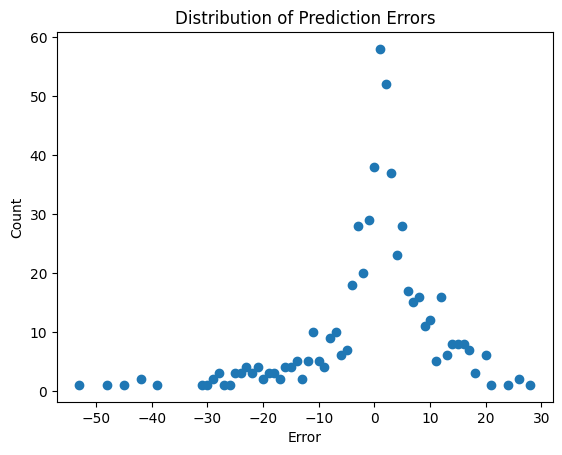

In [78]:
X_train_val_df = step4_dev_norm_df.copy()

forest = RandomForestRegressor(n_estimators=100, n_jobs=9, random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
# 10.377581109938676

## Prediction

### Our own regressor

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

11.941931908045056

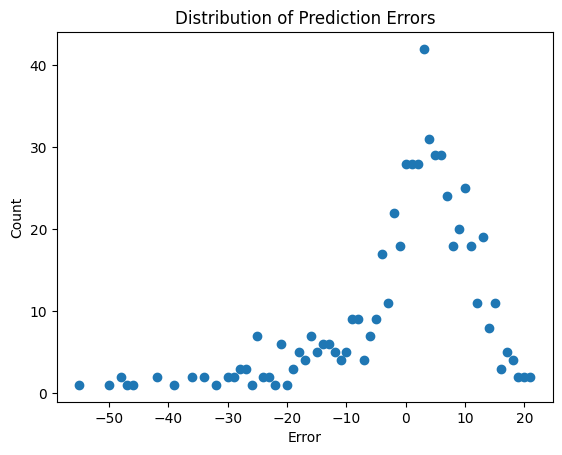

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

TripleForestWithGenderDivision(female_params={'n_estimators': 300, 'n_jobs': 9,
                                              'random_state': 341967},
                               full_params={'n_estimators': 300, 'n_jobs': 9,
                                            'random_state': 341967},
                               male_params={'n_estimators': 300, 'n_jobs': 9,
                                            'random_state': 341967})

In [79]:
another_tfr = TripleForestWithGenderDivision(
    {
        'n_estimators': 300,
        'n_jobs': 9,
        'random_state': 341967
    },
    {
        'n_estimators': 300,
        'n_jobs': 9,
        'random_state': 341967
    },
    {
        'n_estimators': 300,
        'n_jobs': 9,
        'random_state': 341967
    },
)

X_train, X_val, y_train, y_val = train_test_split(step4_dev_norm_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

another_tfr.fit(X_train, y_train)
y_pred = another_tfr.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred.values, y_val, 0)

another_tfr.fit(step4_dev_norm_df, ages_df)

### Upload

In [80]:
y_eval_pred = another_tfr.predict(step4_eval_norm_df)

with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")

c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_female_df.drop(columns=['gender'], axis=1, inplace=True)


## Fine tuning

In [81]:
def tfr_fine_tuning():
    full_param_grid = {
        'n_estimators': [300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [341967]
    }

    male_param_grid = {
        'n_estimators': [300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [341967]
    }

    female_param_grid = {
        'n_estimators': [300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [341967]
    }

    grid_search = GridSearchCV(
        estimator=TripleForestWithGenderDivision(), 
        param_grid=CombinationHyperParameters(
            full_param_grid, 
            male_param_grid, 
            female_param_grid
        ).generate(), 
        cv=5, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=9
    )

    grid_search.fit(step4_dev_norm_df, ages_df)

    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)

    best_tfr = grid_search.best_estimator_
    test_score = best_tfr.score(step4_dev_norm_df, ages_df)
    print("Test Accuracy:", test_score)

    return best_tfr


## Result

In [82]:
grid_search = GridSearchCV(
    estimator=TripleForestWithGenderDivision(), 
    param_grid=CombinationHyperParameters(
        {'n_estimators': [500], 'max_depth': [10], 'min_samples_split': [10], 'min_samples_leaf': [2], 'random_state': [341967], 'n_jobs': [9]}, 
        {'n_estimators': [500], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [4], 'random_state': [341967], 'n_jobs': [9]}, 
        {'n_estimators': [500], 'max_depth': [10], 'min_samples_split': [5], 'min_samples_leaf': [1], 'random_state': [341967], 'n_jobs': [9]}
        ).generate(), 
    cv=5, scoring='neg_root_mean_squared_error', n_jobs=9)

grid_search.fit(step4_dev_norm_df, ages_df)

print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_tfr = grid_search.best_estimator_

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

Best Cross-Validation Accuracy: -10.287622112233596


c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_female_df.drop(columns=['gender'], axis=1, inplace=True)


9.585291787594262

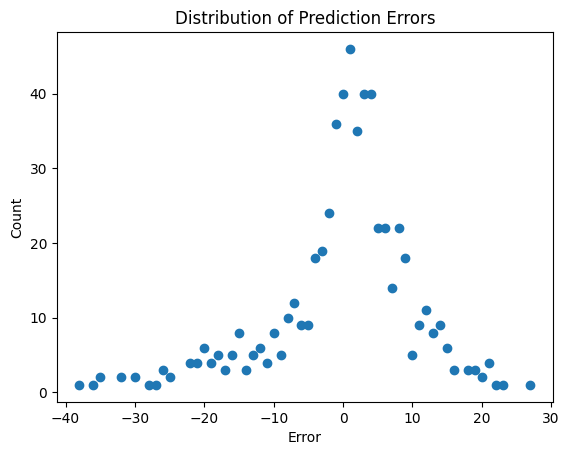

In [83]:
X_train, X_val, y_train, y_val = train_test_split(step4_dev_norm_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

y_pred = best_tfr.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred.values, y_val, 0)
# 9.60961532998382

In [ ]:
X_train_val_df = step4_dev_norm_df.copy()

hist = HistGradientBoostingRegressor(random_state=341967, categorical_features=X_train_val_df.dtypes == 'object')

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

hist.fit(X_train, y_train)
y_pred = hist.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
# 9.916223846607522

# Upload section

In [84]:
with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(best_tfr.predict(step4_eval_norm_df)):
        fout.write(f"{id},{y}\n")

c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
c:\Users\Utente\Desktop\Data-Science-Lab-process-and-methods-2024-25-WInter-Assignment\CustomRegressor.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_female_df.drop(columns=['gender'], axis=1, inplace=True)
